# Electrical Thermal Response Test (E-TRT) : Synthetic Application

This notebook explores the idea of using borehole DC resistivity to monitor the temperature change in the bedrock during a thermal response test. The temperature dependence of electrical resistivity allows to use DC measurements to monitor the temperature change and infer the thermal properties of the rock around the borehole. The estimated thermal parameters are the volumetric heat capacity $C_s$, the thermal conductivity $k$ and the temperature/electrical conductivity coupling $m$.

This notebook contains the following sections:
1. Modelling the temperature with the infinite cylindrical source
2. Confidence interval estimation using the MAP
3. Inversion
4. Visualisation of the cost function space
5. Parameter estimation sensitivity

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from simpeg.electromagnetics.static.utils import apparent_resistivity_from_voltage
from simpeg import (maps,utils)
from etrt import print_matrix, bayesian_inversion, simulate_etrt, simulate_ert, ICS, ert_setup, CTi, get_Cdi, dt2sigma

In [2]:
plt.rcParams.update({'font.size': 9,'axes.labelsize': 8,'xtick.labelsize': 8,'ytick.labelsize': 8,'legend.fontsize': 8,'figure.titlesize': 9,'lines.markersize': 8,})

# 1. Electrical resistivity modelling of a thermal reponse test

## Modelling the temperature with the infinite cylindrical source

We use the function `lib_etrt.ICS` to compute the temperature change in a borehole with the infinite cylindrical source model from 

- Carslaw, H.S., Jaeger, J.C., 1959. Conduction of heat in solids. 2e ed.,Oxford: Clarendon Press

In [3]:
help(ICS)

Help on function ICS in module etrt.lib_etrt:

ICS(r: numpy.ndarray, t: numpy.ndarray, q: float, k: float, c: float, rbh: float, device: str = None, getJ: bool = False, Jtype: str = 'fd', eps: float = 1e-08) -> Union[numpy.ndarray, Tuple[numpy.ndarray, numpy.ndarray]]
    Compute the temperature variation ΔT(r, t) at distance r from the center
    of a borehole of radius rbh, after time t since the start of a constant
    rate injection q, in a medium with thermal conductivity k and volumetric
    heat capacity c. The solution is given by the integral:

        ΔT(r, t) = (q / k π²) ∫₀^∞ [exp(-β²z) - 1] ×
                   [J₀(pβ) Y₁(β) - Y₀(pβ) J₁(β)] / [β² (J₁²(β) + Y₁²(β))] dβ

    where:
        z  = (k / c) × (t / rbh²) = Fourier number
        p  = r / rbh
        J₀, J₁ = Bessel functions of the first kind
        Y₀, Y₁ = Bessel functions of the second kind

    :param r:      Distances from borehole center [m], shape: (nr,)
    :param t:      Times since injection start [s], 

## Temperature dependence of the electrical resistivity
We here follow the work of

- Hayley, K., Bentley, L. R., Gharibi, M., & Nightingale, M. (2007). Low temperature dependence of electrical resistivity: Implications for near surface geophysical monitoring. Geophysical Research Letters, 34(18).

The linear model for the temperature dependence of the electrical conductivity is given by:

$$
\frac{\sigma}{\sigma_{25}} = m (T-25) + 1
$$

where $\sigma_{25}$ is the electrical conductivity at 25°C, $m$ is the temperature coefficient of the electrical conductivity and $T$ is the temperature in °C.

The conductivity difference caused by the temperature change is given by:

\begin{align}
\Delta \sigma &=  m (T_1-25) \sigma_{25} + \sigma_{25} - m (T_2-25) \sigma_{25} - \sigma_{25} \\
&= m (T_1-T_2) \sigma_{25}
\end{align}

The electrical conductivity provided a reference temperature $T_0$ is given by:
$$
\sigma = m (T-T_0) \sigma_{25} + \sigma_{0}
$$

This can be computed with the function `lib_etrt.dt2sigma`.


In [4]:
help(dt2sigma)

Help on function dt2sigma in module etrt.lib_etrt:

dt2sigma(dt: Union[float, numpy.ndarray], m: float, sigma25: float, sigma0: float = None) -> Union[float, numpy.ndarray]
    Compute the electrical conductivity from a temperature change.

    The relationship is given by:

        σ(T) = σ₀ + m × σ₂₅ × ΔT

    where:
        σ(T)  = electrical conductivity at temperature T [S/m]
        σ₀    = reference conductivity [S/m] (defaults to σ₂₅)
        σ₂₅   = electrical conductivity at 25°C [S/m]
        m     = temperature coefficient of conductivity [1/K]
        ΔT    = temperature change from reference [K]

    :param dt:      Temperature change [K], shape: (n,)
    :param m:       Temperature coefficient of conductivity [1/K]
    :param sigma25: Electrical conductivity at 25°C [S/m]
    :param sigma0:  Reference conductivity [S/m], defaults to sigma25

    :return: Electrical conductivity [S/m], shape: (n,)



## SimPEG model

To model the DC electric response, we use the SimPEG library. A more thorough discussion on the DC modeling is found in the notebook `simpeg_dc_cyl.ipynb`. Here, we use a 2D cylindrical mesh to model the DC response, that was optimized in the aforementionned notebook. The function `lib_etrt.ert_setup` creates the mesh, the survey and the simulation.

In [5]:
help(ert_setup)

Help on function ert_setup in module lib_etrt:

ert_setup(zrec: numpy.ndarray, mesh_selection: Union[str, tuple] = 'fast')
    Initialize the ERT modeling for pole-pole borehole measurements with
    an axi-symmetric cylindrical grid. Electrodes are placed at r=0.

    :param zrec:           Position of the M electrode w.r.t A at z=0 [m],
                           shape: (nrec,)
    :param mesh_selection: Selection of the mesh quality. Either "fast" or
                           "accurate", or a tuple (hr, hz) for custom grid

    :return:
        mesh       : SimPEG Cylindrical mesh
        simulation : SimPEG simulation object
        survey     : SimPEG survey object



We create the survey for the DC simulation. We use a pole-pole survey with the electrode A and M located in the borehole and B and N located at infinity. We make the assumption that we are far away from the surface and can consider a full space. We consider separations from 25 cm to 2 m between the electrodes A and M.

In [6]:
zrec = np.arange(0.25, 2.25, 0.25)  # Electrode separation
mesh, simulation, survey= ert_setup(zrec, mesh_selection="fast")

/Users/gabfab/py312/lib/python3.12/site-packages/simpeg/base/pde_simulation.py:639: PerformanceWarning: The 'pymatsolver.SolverLU' solver might lead to high computation times. We recommend using a faster alternative such as 'pymatsolver.Pardiso' or 'pymatsolver.Mumps'.
  super().__setattr__(name, value)


In [7]:
print("the mesh has {} cells".format(mesh.nC))

the mesh has 115200 cells


## Perform the simulation of the forward model

We compute the data (temperature variation and apparent resistivity variation) for given thermal properties of the bedrock.

In [8]:
# Bedrock thermal parameters
C = 2.5     # volumetric heat capacity (MJ/m^3/K)
k = 2.75    # thermal conductivity (W/m/K)
m = 0.035   # ratio between electrical conductivity and temperature (/degC)

We simulate the apparent resistivity at different time steps during TRT experiment. We chose electrical resistivity tomography (ERT) measurements every 4 hours and TRT measurements every 10 minutes until 72 hours. The measurements differ for the two datasets because of the greater computation time and longer measuring periods on the field for ERT.

In [9]:
# SCW parameters
rBH = 0.165/2  # Radius of borehole (m)
Rb = 0  # SCW thermal resistance (mK/W)

# Thermal parameters
T0 = 10   # Initial water temperature (degC)
q = 115.6 # Heat injection rate (W/m)

# Electrical parameters
sigma_ref = 1/15  # Rock electrical conductivity at reference (S/m)
sigmaw_ref = 0.5  # Water electrical conductivity at reference (S/m)

The data should be considered passed a characteristic time to exclude short-term modelling error :

In [10]:
print('The characteristic time is', round(5*rBH**2/(k/(C*1e6))/3600, 2), 'hours')

The characteristic time is 8.59 hours


In [11]:
t_TRT = np.arange(12, 72 + 10/70, 10/60)    # TRT sampling (h) 
t_ERT = np.r_[0, np.arange(12, 72+1, 4)]    # Electrical resistivity sampling (h)

print('We keep temperature and electrical measurements from :', t_ERT[1], t_TRT[0], 'hours onwards')
print('The electrical resistivity data is sampled at :', t_ERT, 'hours')

We keep temperature and electrical measurements from : 12 12.0 hours onwards
The electrical resistivity data is sampled at : [ 0 12 16 20 24 28 32 36 40 44 48 52 56 60 64 68 72] hours


The TRT dataset is obtained from modelling the temperature variation at the borehole wall, obtained with the ICS.

In [12]:
dT_bh = ICS(rBH, t_TRT*3600, q, k, C, rBH)
dT_bh = np.vstack((np.ones(1).reshape(-1, 1) * 0, dT_bh.reshape(-1, 1)))

To obtain the electrical response, we compute the temperature change across the radial grid at every distance r contained in the mesh.
We define the radial mesh, which contains two domains, the SCW and the bedrock.

In [13]:
r = mesh.cell_centers_x
rock = mesh.gridCC[:, 0] > rBH
r_borehole = int(np.count_nonzero(~rock)/mesh.shape_cells[2])  
r_rock = int(r.shape[0])-r_borehole

In [14]:
# Radial temperature change in the bedrock
dT = ICS(r[r_borehole:], t_ERT*3600, q, k, C, rBH)

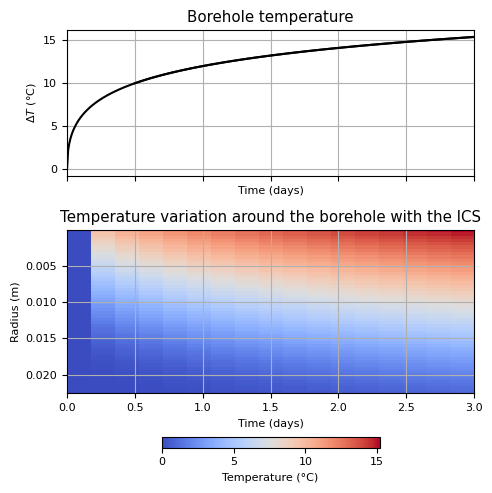

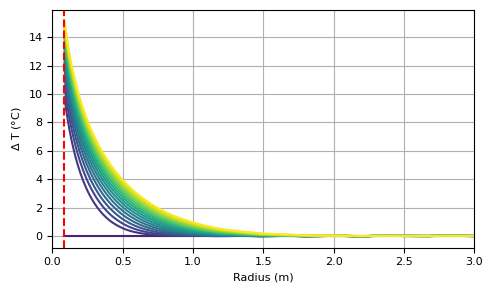

In [15]:
i_1m = next((i for i, dr in enumerate(r[r_borehole:]) if dr > 1), None)

fig, ax = plt.subplots(2, 1, figsize=(5, 5), sharex=True, height_ratios=[2, 3])

ax[0].set_title('Borehole temperature')

ax[0].plot(t_TRT/24, dT_bh[1:], 'k')
ax[0].plot(np.arange(0, 72, 0.2)/24, ICS(rBH, np.arange(0, 72, 0.2)*3600, q, k, C, rBH), 'k')
ax[0].set_ylabel('$\\Delta T$ (°C)')
ax[0].set_xlabel('Time (days)')
ax[0].grid()

ax[1].set_title('Temperature variation around the borehole with the ICS')

heatmap = ax[1].imshow(
    dT[:, :i_1m].T, 
    aspect='auto', 
    cmap='coolwarm', 
    extent=[t_ERT[0]/24, t_ERT[-1]/24, r[i_1m], r[0]])

# Add a color bar to show the temperature scale
cbar = plt.colorbar(heatmap, ax=ax[1], orientation='horizontal', pad=0.2, fraction=0.05) 
cbar.set_label('Temperature (°C)')


ax[1].set_xlabel('Time (days)')
ax[1].set_ylabel('Radius (m)')
ax[1].grid()

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(5, 3))

colors = plt.cm.viridis(np.linspace(0.1, 1, dT.shape[0])) 

# Plot each temperature profile with a color from the colormap
for i in range(dT.shape[0]):
    ax.plot(r[r_borehole:],dT[i].T, color=colors[i])

ax.axvline(x=rBH, color='red', linestyle='--', label='Borehole Radius')
ax.grid()
ax.set_xlabel('Radius (m)')
ax.set_ylabel('$\\Delta$ T (°C)')
ax.set_xlim(0, 3)

plt.tight_layout()

The radial conductivity profile is generated in the bedrock

In [16]:
# Conductivity profile in the rock with respect to temperature profile
sigma_T = dt2sigma(dT, m, sigma_ref)    

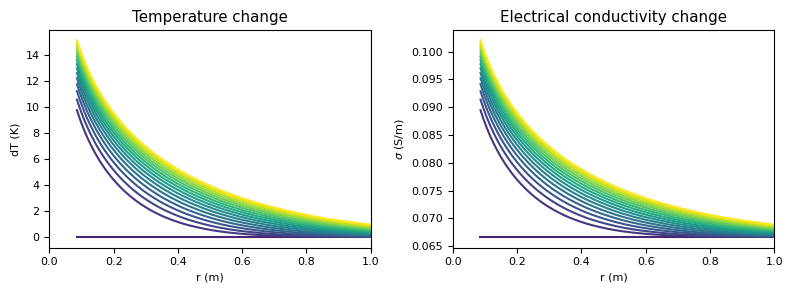

In [17]:
fig, ax = plt.subplots(1, 2,figsize=(8, 3))

for i in range(dT.shape[0]):
    ax[0].plot(r[r_borehole:],dT[i], color=colors[i])
ax[0].set_xlabel('r (m)')
ax[0].set_ylabel('dT (K)')
ax[0].set_xlim([0, 1])
ax[0].set_title('Temperature change')
for i in range(dT.shape[0]):
    ax[1].plot(r[r_borehole:],sigma_T[i].T, color=colors[i])
ax[1].set_xlabel('r (m)')
ax[1].set_ylabel('$\\sigma$ (S/m)')
ax[1].set_xlim([0, 1])
ax[1].set_title('Electrical conductivity change')
plt.tight_layout()
plt.show()

Because the relation between the temperature and the electrical conductivity is linear, both profiles have the same shape. The electrical conductivity change is however much smaller than the temperature change.

We can now compute the DC response for this temperature change. First, we need to map the conductivity change on the mesh.


In [18]:
# Initial water electrical conductivity (S/m)
sigmaw = sigmaw_ref * np.ones(len(t_ERT))

# Create time-lapse radial model
rmodel = np.vstack((np.ones((r_borehole, len(t_ERT)))*sigmaw.reshape(1, -1), sigma_T.T)).T
start_model = np.tile(rmodel, mesh.vnC[-1])
map = maps.IdentityMap(mesh)

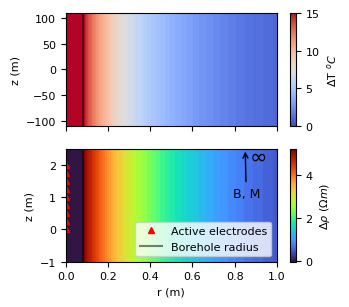

In [19]:
fig, ax = plt.subplots(2, 1, figsize=(9/2.54, 8/2.54), sharex=True)

n_pad = np.sum(r < rBH)
pad_left = np.ones(n_pad) * dT[-1, 0]
conv_full = np.concatenate((pad_left, dT[-1]))  
conv_image = np.tile(conv_full.reshape(1, -1), (11, 1))  

im0 = ax[0].pcolormesh(r, np.linspace(-100, 100, 11), conv_image, shading='auto', cmap='coolwarm', vmin=0, vmax=15) 
ax[0].axvline(x=rBH, color='k', linestyle='-', alpha=0.5, label='Borehole radius')
ax[0].set_ylabel('z (m)')
fig.colorbar(im0, ax=ax[0], orientation='vertical', label='$\\Delta$T $^oC$')

im1 = mesh.plot_image(map * (1/start_model[0,:] - 1/start_model[-1,:]), ax=ax[1], grid=False, pcolor_opts={"cmap": "turbo"})
ax[1].set_ylim(-1,2.5)
ax[1].set_xlim(0,1)
ax[1].plot(np.zeros(len(zrec)+1), np.concatenate([[0], zrec]), 'r^', markersize=5, label='Active electrodes')
ax[1].set_ylabel('z (m)')
ax[1].set_xlabel('r (m)')
ax[1].axvline(x=rBH, color='k', linestyle='-', alpha=0.5, label='Borehole radius')
ax[1].legend(loc='lower right')
fig.colorbar(im1[0], ax=ax[1], orientation='vertical', label=r'$\Delta\rho$ $(\Omega m)$', )

ax[1].text(0.87, 2.1, r"$\infty$", color='k', fontsize=15)
ax[1].annotate("B, M", xy=(0.85, 2.5), xytext=(0.79, 1),arrowprops=dict(arrowstyle="->",facecolor='black', linewidth=1), color='k')

plt.tight_layout()
plt.show()

We compute the apparent resistivity measured by the different electrode spacings during the TRT.

In [21]:
dpred = np.zeros((start_model.shape[0], zrec.size))
for i in range(start_model.shape[0]):
    dpred[i] = simulation.dpred(start_model[i,:])
apparent_res = apparent_resistivity_from_voltage(survey, dpred, space_type="whole-space")

/Users/gabfab/py312/lib/python3.12/site-packages/pymatsolver/wrappers.py:81: SparseEfficiencyWarning: splu converted its input to CSC format
  self.solver = fun(self.A, **self.kwargs)
/Users/gabfab/py312/lib/python3.12/site-packages/pymatsolver/solvers.py:415: FutureWarning: In Future pymatsolver v0.4.0, passing a vector of shape (n, 1) to the solve method will return an array with shape (n, 1), instead of always returning a flattened array. This is to be consistent with numpy.linalg.solve broadcasting.
  return self.solve(val)


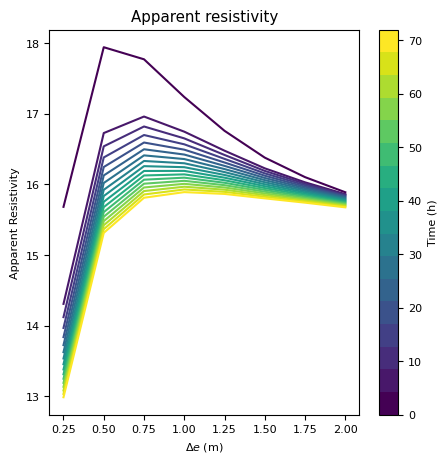

In [23]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
colors = plt.cm.viridis(np.linspace(0, 1, len(t_ERT)))
for ii, t in enumerate(t_ERT):
    ax.plot(zrec, apparent_res[ii, :], label="t={:.1f}h".format(t), color=colors[ii])
    
cmap = mcolors.ListedColormap(colors)
plt.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin=0, vmax=t_ERT.max()), cmap=cmap), ax=ax, label='Time (h)')
ax.set_xlabel('$\\Delta e$ (m)')
ax.set_ylabel('Apparent Resistivity')
#ax.set_xlim([zrec[0], zrec[-1]])
ax.set_title('Apparent resistivity')
plt.show()

Electrodes with separation larger than 2 m see little apparent resistivity changes. We also see that resistivity changes are more important at later times.

We can now compute the change in apparent resistivity with respect to the initial measurement, where the ground temperature is undisturbed.

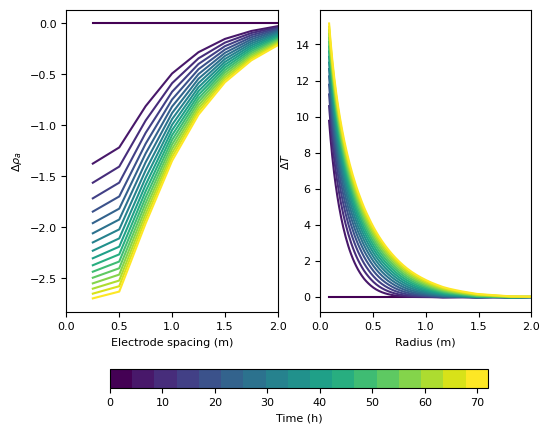

In [25]:
d_apparent_res = apparent_res - apparent_res[0, :]

fig, ax = plt.subplots(1, 2, figsize=(6, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(t_ERT)))
for ii, t in enumerate(t_ERT):
    ax[0].plot(zrec, d_apparent_res[ii, :], label="t={:.1f}h".format(t), color=colors[ii])
    ax[1].plot(r[r_borehole:], dT[ii, :], color=colors[ii])

ax[0].set_xlabel('Electrode spacing (m)')
ax[1].set_xlabel('Radius (m)')
ax[0].set_ylabel('$\\Delta \\rho_a$')
ax[1].set_ylabel('$\\Delta T$')
for a in ax:
    a.set_xlim([0, zrec[-1]])
    
fig.subplots_adjust(bottom=0.25)
#cax = fig.add_axes([0.15, 0.10, 0.7, 0.04])
fig.colorbar(plt.cm.ScalarMappable(norm=plt.Normalize(vmin=0, vmax=t_ERT.max()), cmap=cmap), orientation='horizontal', fraction=0.05, pad=0.15, ax=ax, label='Time (h)')

plt.show()

We can compare temperature changes in time with apparent resistivity changes. Their trends are reversed, as the resistivity decreases when temperatures increase. We see here that electrodes with a separation of 2 m measure changes smaller than 1%. We thus needs electrode separation smaller than 2 m to sense temperature changes.

## E-TRT simulation and Jacobian

Several parameters affect the TRT experiment, such as $k$ and $C_s$. In addition, the electrical measurements required the knowledge of the $m$ values.

We use the `lib_etrt.simulate_ert` function to simulate the apparent resistivity response and compute its Jacobian. 

In [26]:
help(simulate_ert)

Help on function simulate_ert in module lib_etrt:

simulate_ert(k: float, crho: float, q: float, m: float, sigma25: float, sigma_water: Union[float, numpy.ndarray], rbh: float, times: numpy.ndarray, mesh, survey, simulation, getJ: bool = False, thermal_model: str = 'ILS') -> Union[numpy.ndarray, Tuple[numpy.ndarray, numpy.ndarray]]
    Simulate the ERT response during a TRT for a set of times after the start
    of a constant rate injection in a borehole. The temperature change is
    computed with the infinite line-source or cylindrical-source model.

    :param k:             Thermal conductivity of the rock [W/m/K]
    :param crho:          Volumetric heat capacity of the rock [MJ/m³/K]
    :param q:             Injection rate per unit length [W/m]
    :param m:             Temperature-conductivity coefficient [1/K]
    :param sigma25:       Electrical conductivity at 25°C [S/m]
    :param sigma_water:   Electrical conductivity of borehole water [S/m],
                          shap

# 3. Confidence interval estimation using the MAP

The function `lib_etrt.simulate_etrt` is used to compute the E-TRT response and the Jacobian matrix. We compute the Jacobian matrix at the true thermal parameters.
The columns of the jacobian are $\partial k/\partial d$, $\partial C_s/\partial d$ and $\partial m/\partial d$ where $d$ is the data vector composed of the stacked ERT and TRT data.

In [27]:
help(simulate_etrt)

Help on function simulate_etrt in module lib_etrt:

simulate_etrt(k: float, crho: float, q: float, m: float, sigma25: float, rbh: float, times_ert: numpy.ndarray, times_trt: numpy.ndarray, mesh, survey, simulation, getJ: bool = False, type: str = 'diff', thermal_model: str = 'ICS', sigma_water: Union[float, numpy.ndarray] = None, param_q: bool = False) -> Union[numpy.ndarray, Tuple[numpy.ndarray, numpy.ndarray]]
    Simulate the combined ERT and TRT response during a constant rate
    injection in a borehole. The temperature change is computed with the
    infinite line-source or cylindrical-source model. The injection rate q
    is included in the output to propagate uncertainties.

    :param k:             Thermal conductivity of the rock [W/m/K]
    :param crho:          Volumetric heat capacity of the rock [MJ/m³/K]
    :param q:             Injection rate per unit length [W/m]
    :param m:             Temperature-conductivity coefficient [1/K]
    :param sigma25:       Electrica

In [28]:
m_true = np.r_[k, C, m]

We start by visualizing the Jacobian for both datasets with respect to each thermal parameter.

In [29]:
tR_fig = np.arange(2, 72 + 2, 2)  # ERT times for plotting
tT_fig = np.arange(2, 72 + 10/60, 10/60)  # TRT times for plotting
d, J_etrt_fig = simulate_etrt(k, C, q, m, sigma_ref, rBH, tR_fig, tT_fig, mesh, survey, simulation, getJ=True, sigma_water=0.5, thermal_model='ICS', type='diff')

Maximum resitivity variation : -2.7 Omega*m =  -17.98 %


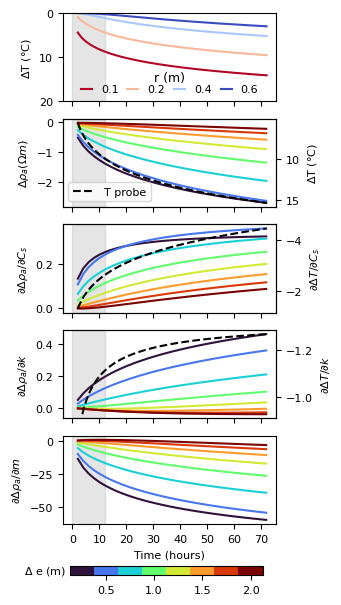

In [44]:
from matplotlib.cm import ScalarMappable

# Plot de Jacobian
nR = len(tR_fig)*len(zrec)
colors = plt.cm.turbo(np.linspace(0, 1, len(zrec)))

# Create a discrete colormap
cm = 1/2.54
fig, ax = plt.subplots(5, 1, figsize=(7*cm, 15*cm), sharex=True)
plt.subplots_adjust(top=0.96, bottom=0.095)

rad = [0.1, 0.2, 0.4, 0.6]
c = plt.cm.coolwarm(np.linspace(1, 0, len(rad)))
for r in range(len(rad)):
    ax[0].plot(tT_fig, ICS(rad[r], tT_fig*3600, q, k, C, rBH).ravel(), color=c[r], label=f'{np.round(rad[r], 2)}')
    
ax[0].legend(title='r (m)',loc='lower center', ncol=4, 
            frameon=False, handlelength=1.0, labelspacing=0.01, columnspacing=0.8, borderpad=0.1)
ax[0].set_ylim(0, 20)
ax[0].invert_yaxis()
JR = J_etrt_fig[:nR]
dR = d[:nR]

print('Maximum resitivity variation :', np.round(min(dR), 2), 'Omega*m = ', np.round(min(dR)/(1/sigma_ref)*100, 3), '%')

cmap = mcolors.ListedColormap(colors)
bounds = np.append(zrec - 0.125, zrec[-1] + 0.125)  
norm = mcolors.BoundaryNorm(bounds, cmap.N)


for t in range(len(zrec)):
    time_days = tR_fig
    ax[1].plot(time_days, dR[t::len(zrec)], '-', color=colors[t])
    ax[2].plot(time_days, JR[t::len(zrec), 1], '-', color=colors[t])
    ax[3].plot(time_days, JR[t::len(zrec), 0], color=colors[t])
    ax[4].plot(time_days, JR[t::len(zrec), 2], color=colors[t])

ax1 = ax[1].twinx()
ax1.invert_yaxis()
ax1.plot(tT_fig, ICS(rBH, tT_fig*3600, q, k, C, rBH).ravel(), color='k', linestyle='--', label='T probe')
ax1.set_ylabel('$\\Delta$T (°C)')
ax1.legend(loc='lower left')

JT = J_etrt_fig[nR:]

ax2 = ax[2].twinx()
ax2.invert_yaxis()
ax2.plot(tT_fig, JT[:,0], color='k', linestyle='--')
ax2.set_ylabel('$\\partial \\Delta T/\\partial C_s$')

ax3 = ax[3].twinx()
ax3.invert_yaxis()
ax3.plot(tT_fig[10:], JT[:,1][10:], color='k', linestyle='--')
ax3.set_ylabel('$\\partial \\Delta T/\\partial k$')

ax[0].set_ylabel('$\\Delta $T (°C)', clip_on=True)
ax[1].set_ylabel('$\\Delta \\rho_a (\\Omega m)$', clip_on=True)
ax[2].set_ylabel('$\\partial \\Delta \\rho_a/\\partial C_s$', clip_on=True)
ax[3].set_ylabel('$\\partial \\Delta \\rho_a/\\partial k$', clip_on=True)
ax[4].set_ylabel('$\\partial \\Delta \\rho_a/\\partial m$', clip_on=True)
ax[4].set_xlabel('Time (hours)', clip_on=True)

for a in ax:
    a.set_xticks(np.arange(0, 75, 10)) 
    a.axvspan(0, 12, color='grey', alpha=0.2, label='Highlighted region')

cbar_axE = fig.add_axes([0.15, 0.008, 0.7, 0.015])  # right colorbar

cbE = fig.colorbar(
    ScalarMappable(norm=norm, cmap=cmap),
    cax=cbar_axE,
    orientation='horizontal',
    ticks=[0, 0.5, 1.0, 1.5, 2.0, 4], 
)
cbE.ax.minorticks_off()
cbE.ax.yaxis.set_label_position('left')
cbE.ax.set_ylabel('$\\Delta$ e (m)', rotation=0, labelpad=18, va='center')

plt.show()

We compute the data and Jacobian now using the right sampling.

In [45]:
data, Jetrt = simulate_etrt(k, C, q, m, sigma_ref, rBH, t_ERT[1:], t_TRT, mesh, survey, simulation, type='diff', thermal_model='ICS', getJ=True, sigma_water=0.5)

The TRT portion of the Jacobian is selected. The column associated to the parameter $m$ is removed, since the temperature data are insensitive to this parameter.

In [46]:
Jtrt = Jetrt[len(t_ERT[1:]) * len(zrec):, :]
Jtrt = np.delete(Jtrt, 2, axis=1)

Sensitivity to noise is given by the condition number of the Jacobian matrix (Aster, eq. 3.90):
$$
\frac{\| \mathbf{m}- \mathbf{m}' \|}{\| \mathbf{m}\|} \leq \text{cond}(\mathbf{J})\frac{\| \mathbf{d}- \mathbf{d}' \|}{\| \mathbf{d}\|}
$$


In [47]:
print("Condition number of TRT: {:.1f}".format(np.linalg.cond(Jtrt)))
print("Condition number of ETRT (without m): {:.1f}".format(np.linalg.cond(Jetrt[:2, :2])))
print("Condition number of ETRT (with m): {:.1f}".format(np.linalg.cond(Jetrt)))

Condition number of TRT: 34.5
Condition number of ETRT (without m): 11.0
Condition number of ETRT (with m): 134.3


We can conclude that:
- Noise propagation is very moderate for the TRT alone
- Noise propagation is reduced for the E-TRT without $m$
- Noise propagation is higher when including $m$, but still reasonable.
- Some regularization might be needed to stabilize the inversion, especially for the E-TRT with $m$.

## Confidence interval

For what follows, we will compute confidence interval with the hypothesis that the data errors are uncorrelated and gaussian. The Bayesian inversion in that case leads to the following expression for the posterior model covariance matrix (Aster, eq. 6.23):

$$
\mathbf{C}_m' = (\mathbf{J}^T \mathbf{C}_D^{-1} \mathbf{J} + \mathbf{C}_m^{-1})^{-1}
$$

where $\mathbf{C}_D$ is the data covariance matrix, $\mathbf{C}_m$ is the prior model covariance matrix and $\mathbf{J}$ is the Jacobian matrix.

We set the temperature error at 0.26C$^o$ and the apparent resistivity at 0.092 $\Omega m$, based on the experimental data in Varennes and generate the data covariance matrix $\mathbf{C}_D$. See notebook `ETRT_Varennes_example.ipynb` for more details. The function `lib_etrt.get_Cdi` creates the inverse of the data covariance matrix.

In [48]:
help(get_Cdi)

Help on function get_Cdi in module lib_etrt:

get_Cdi(tR: numpy.ndarray, tT: numpy.ndarray, de: numpy.ndarray, sigma_ert: float = 0.092, sigma_trt: float = 0.26, varT: float = 0.013, a: float = 7, covariogram: bool = True, sigma_q: bool = None)
    Get covariance matrix
    :param tR: time points for ERT (hours), shape: (nR,)
    :param tT: time points for TRT (hours), shape: (nT,)
    :param de: electrode separations (m), shape: (ne,)
    :param sigma_ert: measurement error for ERT
    :param sigma_trt: measurement error for TRT
    :param sigma_q: measurement error for injection rate
    :param varT: temperature covariance value (degC^2)
    :param covariogram: use covariogram with correlated residuals for TRT data
    :return: inversion of E-TRT covariance/precision matrix, shape: (ne*nR+nT, ne*nR+nT)



In [49]:
sigma_ert=0.092
sigma_trt=0.26
a=7
varT=0.013

In [50]:
Cdi = get_Cdi(t_ERT[1:], t_TRT,  zrec, sigma_ert, sigma_trt, varT, a)   # E-TRT
Cdi_trt = Cdi[len(zrec) * len(t_ERT[1:]):, len(zrec) * len(t_ERT[1:]):]       # TRT

We define the prior model covariance matrix $\mathbf{C}_m$ based on the feasible range of each parameter. We use the gaussian approximation of a bounded interval.

In [51]:
sigma_lss=np.sqrt((1 - 5) ** 2 / 12)
sigma_crho=np.sqrt((2 - 3.5) ** 2 / 12)
sigma_m=np.sqrt((0.03) ** 2 / 12)
Cmp = np.diag([sigma_lss, sigma_crho, sigma_m])**2

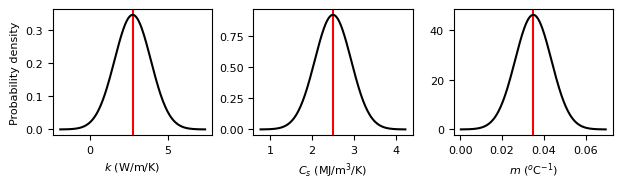

In [52]:
fig, axs = plt.subplots(1, 3, figsize=(16/2.54, 5/2.54))
labels = [r'$k$ (W/m/K)', r'$C_s$ (MJ/m$^3$/K)', r'$m$ ($^o$C$^{-1}$)']

for i in range(3):
    axs[i].axvline(m_true[i], color='r')
    axs[i].set_xlabel(labels[i])
    # Generate x values
    sigma = np.sqrt(Cmp[i,i])
    mu = m_true[i]
    x = np.linspace(mu - 4*sigma, m_true[i] + 4*sigma, 200)
    # Compute Gaussian (normal) PDF
    y = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma)**2)
    axs[i].plot(x, y, 'k-')
    
axs[0].set_ylabel('Probability density')
plt.tight_layout()
plt.show()

We first look at the non-regularized solution, where $\mathbf{C}_m^{-1} = 0$.

In [53]:
print_matrix(np.linalg.inv(Jtrt.T@Cdi_trt@Jtrt)*100000, "\\pmb{c}_{TRT}' =")
print_matrix(np.linalg.inv(Jetrt.T@Cdi@Jetrt)*100000, "\\pmb{c}_{ETRT}' =")

<IPython.core.display.Math object>

<IPython.core.display.Math object>

With the prior information:

In [54]:
print_matrix(np.linalg.inv(Jtrt.T@Cdi_trt@Jtrt + np.linalg.inv(Cmp[:-1, :-1]))*100000, "\\pmb{c}_{TRT}' =")
print_matrix(np.linalg.inv(Jetrt.T@Cdi@Jetrt + np.linalg.inv(Cmp))*100000, "\\pmb{c}_{ETRT}' =")

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Some conclusions:
- Prior information is not required for both TRT and ETRT, as the covariance matrix is not singular.
- Prior information marginally reduces the covariance in both cases.
- ETRT shows lower covariance for both $k$ and $C_s$.

For the following, we will not keep the prior as it will bias the confidence intervals, and the inversion.

We calculate the confidence interval just for the TRT data

In [55]:
Cm_trt = np.linalg.inv(Jtrt.T@Cdi_trt@Jtrt)
conf_trt = 1.96 * np.sqrt(np.diag(Cm_trt))

print('                             k         Cs')
print('TRT confidence interval', 1.96 * np.sqrt(np.diag(Cm_trt)))
print('TRT confidence interval', 1.96 * np.sqrt(np.diag(Cm_trt))/m_true[:-1] * 100, '%')

                             k         Cs
TRT confidence interval [0.20590602 0.63583051]
TRT confidence interval [ 7.48749156 25.43322023] %


We calculate the confidence interval for the E-TRT data

In [56]:
Cm_etrt = np.linalg.inv(Jetrt.T@Cdi@Jetrt)
conf_etrt = 1.96 * np.sqrt(np.diag(Cm_etrt))

print('                             k         Cs         m')
print('ETRT confidence interval', 1.96 * np.sqrt(np.diag(Cm_etrt)))
print('ETRT confidence interval', 1.96 * np.sqrt(np.diag(Cm_etrt))/m_true * 100, '%')

                             k         Cs         m
ETRT confidence interval [0.07142431 0.21345283 0.00133332]
ETRT confidence interval [2.59724753 8.53811337 3.8094895 ] %


The gain of the E-TRT over a standard TRT can be calculated for *k* and *Cs*

In [57]:
print("Confidence ratio (TRT / ETRT):", conf_trt / conf_etrt[:-1])
print("Uncertainty reduction (%) with ETRT vs TRT :",
      (conf_trt - conf_etrt[:2]) / conf_trt * 100)

Confidence ratio (TRT / ETRT): [2.88285636 2.9787869 ]
Uncertainty reduction (%) with ETRT vs TRT : [65.31218091 66.429287  ]


Adding electrical resistivity allows improving uncertainty in k and C by 65 \%, reducing it by a factor of 3.

# 3. Inversion

Both the TRT data, consisting of temperature variations $\Delta T$, and the ERT data, consisting of apparent resistivity variations $\Delta \rho_a$, can be inverted jointly to estimate the thermal and electrical parameters of the subsurface ($k$, $C_s$ and $m$).

We use Bayes Theorem where we obtain the maximum a posteriori estimate (MAP) of the model parameters by minimizing the following cost function :

$$
\Phi(\mathbf{m}) = \;\Phi(\mathbf{m})_T + \Phi(\mathbf{m})_{\rho} + \Phi(\mathbf{m})_{\text{prior}}\\
    = (\mathbf{\Delta T}(\mathbf{m}) - \mathbf{\Delta T})^T \mathbf{C}_T^{-1} (\mathbf{\Delta T}(\mathbf{m}) - \mathbf{\Delta T})
    + (\mathbf{\Delta\rho_a}(\mathbf{m}) - \mathbf{\Delta\rho_a})^T \mathbf{C}_{\rho_a}^{-1} (\mathbf{\Delta\rho_a}(\mathbf{m}) - \mathbf{\Delta\rho_a})
    + 
    (\mathbf{m} - \mathbf{m}_0)^T \mathbf{C}_m^{-1} (\mathbf{m} - \mathbf{m}_0).
$$

We now perform the inversion using the Gauss-Newton method :

$$
\mathbf{m}_{n+1} = \mathbf{m}_n - \left(\mathbf{J}^T\mathbf{C}_D^{-1}\mathbf{J} + \mathbf{C}_m^{-1}\right)^{-1}\left(\mathbf{J}^T\mathbf{C}_D^{-1}\left(\mathbf{d}_{mod}-\mathbf{d}\right) + \mathbf{C}_m^{-1}\left(\mathbf{m}_n - \mathbf{m}_0\right)\right)
$$

over the noiseless synthetic data. We use the `lib_etrt.bayesian_inversion` function to perform the inversion.

In [58]:
help(bayesian_inversion)

Help on function bayesian_inversion in module lib_etrt:

bayesian_inversion(d: numpy.ndarray, m0: numpy.ndarray, Cmi: numpy.ndarray, Cdi: numpy.ndarray, fun: <built-in function callable>, niter: int, step: float = 1, prior: bool = True, doprint: bool = False, minit: numpy.ndarray = None) -> Tuple[numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray]
    Perform Bayesian linearized inversion using the Gauss-Newton method.

    The update equation at each iteration is:

        m^(i+1) = m^(i) - step × [J^T C_d^(-1) J + C_m^(-1)]^(-1) ×
                          [J^T C_d^(-1) (d_pred - d_obs) + C_m^(-1) (m^(i) - m_0)]

    where:
        m^(i)     = model parameters at iteration i
        m_0       = prior/reference model
        d_obs     = observed data
        d_pred    = predicted data from forward model
        J         = Jacobian matrix (sensitivities)
        C_d^(-1)  = inverse data covariance matrix
        C_m^(-1)  = inverse model covariance matrix
        step      = s

## TRT inversion

We start by inverting the temperature data, only sensitive for $k$ and $C_s$

In [59]:
m0 = np.r_[2.6, 2, 0.018]
mtrue = np.r_[k, C, m]

def fun(m):
    dt, J = ICS(rBH, t_TRT * 3600, q, m[0], m[1], rBH, getJ=True, eps=1e-5)
    J = np.delete(J, 2, axis=1)
    return dt, J

d, J = fun(mtrue)
m_est, *_ = bayesian_inversion(d, m0[:-1], None, Cdi_trt, fun, 10,
                           step=0.8, doprint=True, prior=False)

print("true:", mtrue)
print("est :", m_est)

iter 0: cost = 7.003553e+02 (data = 7.003553e+02)model_params = [2.71496428 2.33467308]
iter 1: cost = 4.822333e+01 (data = 4.822333e+01)model_params = [2.74282833 2.46024408]
iter 2: cost = 2.346118e+00 (data = 2.346118e+00)model_params = [2.74856239 2.49167239]
iter 3: cost = 9.856727e-02 (data = 9.856727e-02)model_params = [2.7497124  2.49831808]
iter 4: cost = 3.983926e-03 (data = 3.983926e-03)model_params = [2.74994248 2.49966295]
iter 5: cost = 1.596931e-04 (data = 1.596931e-04)model_params = [2.7499885  2.49993256]
iter 6: cost = 6.390422e-06 (data = 6.390422e-06)model_params = [2.7499977  2.49998651]
iter 7: cost = 2.556384e-07 (data = 2.556384e-07)model_params = [2.74999954 2.4999973 ]
iter 8: cost = 1.022571e-08 (data = 1.022571e-08)model_params = [2.74999991 2.49999946]
iter 9: cost = 4.090297e-10 (data = 4.090297e-10)model_params = [2.74999998 2.49999989]
true: [2.75  2.5   0.035]
est : [2.74999998 2.49999989]


The true thermal parameters are perfectly recovered.

We run a Monte-Carlo simulation to evaluate the sensitivity of the TRT inversion to noise.

In [77]:
def fun(m):
    dt, J = ICS(rBH, t_TRT * 3600, q, m[0], m[1], rBH, getJ=True, eps=1e-5)
    J = np.delete(J, 2, axis=1)
    return dt, J

nmc = 10000
m_mc = []
cost = []
mn = []

mtrue = np.r_[k, C]
d = fun(mtrue)[0]
d_est, Jest = fun(m_est)
Cdi_trt_inv = np.linalg.inv(Cdi_trt)

for i in range(nmc):
    success = False 
    attempt = 0 
        
    while not success: 
        attempt += 1 
        dnoise = np.random.multivariate_normal(mean=d, cov=Cdi_trt_inv)
        m0i = m_est + np.random.normal(0, np.sqrt(np.diag(Cmp[:-1, :-1])), m_est.shape)
        m0i = np.abs(m0i) # make sure values are positive
            
        try:
            mm = bayesian_inversion(dnoise, m0i, None, Cdi_trt, fun, 10, step=.8, prior=False)[0]
            success = True

        except Exception as e: 
            print(f"Sample {i}, attempt {attempt}: failed ({e})") 
            continue
    m_mc.append(mm)
    r = fun(mm)[0] - d
    cost.append(r.T @ Cdi_trt @ r)

m_mc = np.array(m_mc)
cost = np.array(cost)

The resulting Monte-Carlo covariance matrix is obtained.

In [78]:
C_mc_trt = (m_mc-np.mean(m_mc, axis=0, keepdims=True)).T@(m_mc-np.mean(m_mc, axis=0, keepdims=True))/(nmc-1)

print('                                  k         Cs')
print('TRT confidence interval       ', 1.96 * np.sqrt(np.diag(Cm_trt)))
print('MC Confidence interval for TRT', 1.96 * np.sqrt(np.diag(C_mc_trt)))

                                  k         Cs
TRT confidence interval        [0.20590602 0.63583051]
MC Confidence interval for TRT [0.20685623 0.64348261]


And plot the results

In [79]:
def covariance_ellipse(Cm, center, ax=None, style='k-'):
    from scipy.stats import chi2
    theta = np.arange(0, 2*np.pi, 0.01).reshape(1, -1)
    delta = np.sqrt(chi2.ppf(0.95, 2))
    lam, u =np.linalg.eig(np.linalg.inv(Cm))
    r=delta/np.sqrt(lam) #the radii for each ellipsoid
    e=r[0]*u[:,:1]@np.cos(theta)+r[1]*u[:,1:]@np.sin(theta) #compute the ellipsoids
    e=e+np.array([center[0], center[1]]).reshape(-1, 1)
    if ax:
        ax.plot(e[0,:], e[1,:], style)
    else :
        plt.plot(e[0,:], e[1,:],style)

/var/folders/kr/nzkb5wxn54xb77rp56p38n3w0000gn/T/ipykernel_79625/3416763716.py:5: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(wspace=0.2, hspace=0.2)


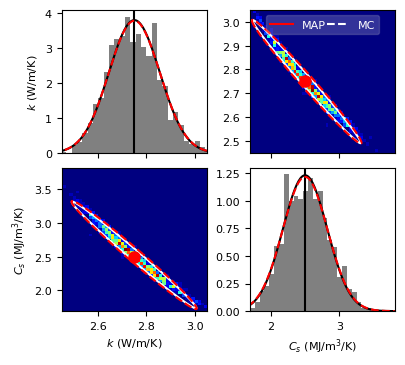

In [80]:
n_params = 2
labels = [r'$k\ \mathrm{(W/m/K)}$', r'$C_s\ \mathrm{(MJ/m^3/K)}$']

fig, axes = plt.subplots(n_params, n_params, figsize=(10/2.54, 9/2.54), constrained_layout=True,sharex='col',)

for i in range(n_params):
    for j in range(n_params):
        ax = axes[i, j]
        
        if i == j:
            # Diagonal: show histogram of each parameter
    
            ax.axvline(mtrue[i], color='k')
            mu = mtrue[i]
            sigma = np.sqrt(Cm_trt[i,i])
            sigma_mc = np.sqrt(C_mc_trt[i,i])
            x = np.linspace(mu - 4*sigma, mtrue[i] + 4*sigma, 200)
            x_mc = np.linspace(mu - 4*sigma_mc, mtrue[i] + 4*sigma_mc, 200)
            
            # Compute Gaussian (normal) PDF
            y = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma)**2)
            y_mc = (1 / (sigma_mc * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x_mc - mu) / sigma_mc)**2)
            ax.plot(x, y, 'k-', label='MAP')
            ax.plot(x_mc, y_mc, 'r--', label='MC')
            ax.hist(m_mc[:, i], bins=30, color='grey', density=True)
            
        else:
            # Off-diagonal: show 2D histogram + ellipse
            
            ax.hist2d(m_mc[:, j], m_mc[:, i], bins=(50, 50), cmap=plt.cm.jet)
            cov_nq = Cm_trt[[j, i], :][:, [j, i]]
            cov_mc = C_mc_trt[[j, i], :][:, [j, i]]
            mean = np.mean(m_mc, axis=0)[[j, i]]
            covariance_ellipse(cov_nq, mean, ax=ax, style='w-')
            covariance_ellipse(cov_mc, mean, ax=ax, style='r--')
            ax.plot(mtrue[j], mtrue[i], 'ro', markersize=8)
            
        # Set labels only on the left and bottom plots
        if i == n_params - 1:
            ax.set_xlabel(labels[j])
        if j == 0:
            ax.set_ylabel(labels[i])
            
import matplotlib.lines as mlines

handle_mc = mlines.Line2D([], [], color='r', linestyle='-', label='MAP')
handle_nq = mlines.Line2D([], [], color='white', linestyle='--', label='MC')

axes[0, 1].legend(handles=[handle_mc, handle_nq], loc='upper center', framealpha=0.2, labelcolor='white', ncol=2, columnspacing=0.1)
axes[0, 1].set_ylim(2.45, 3.05)
axes[1, 0].set_xlim(2.45, 3.05)
#axes[0, 0].set_ylim(1, 4)
#axes[1, 1].set_xlim(1, 4)

plt.show()

Some conclusions :
- The TRT inversion recovers the thermal parameters from noiseless data
- The Monte-Carlo simulation confirms the Gaussian assumption for the thermal parameters
- The Monte-Carlo shows that noisy data will yield uncertainties of 28 % for $Cs$

## E-TRT inversion

We now perform the inversion for the E-TRT case, where both temperature and apparent resistivity are measured. We thus invert for $k$, $C_s$ and $m$.

In [81]:
def fun(m):

    d, J = simulate_etrt(m[0], m[1], q, m[2], sigma_ref, rBH, t_ERT, t_TRT,
                              mesh, survey, simulation, getJ=True,
                              thermal_model='ICS', type='diff',sigma_water=sigmaw_ref)
    return d, J

m_est, *_ = bayesian_inversion(data, m0, None, Cdi, fun, 10,
                           step=0.8, doprint=True, prior=False)

iter 0: cost = 3.757635e+03 (data = 3.757635e+03)model_params = [2.75645107 2.22190915 0.02882106]
iter 1: cost = 3.014707e+02 (data = 3.014707e+02)model_params = [2.76972512 2.37924084 0.0332622 ]
iter 2: cost = 1.507684e+01 (data = 1.507684e+01)model_params = [2.75984238 2.45619186 0.03456117]
iter 3: cost = 6.039571e-01 (data = 6.039571e-01)model_params = [2.75351136 2.48624804 0.03489311]
iter 4: cost = 2.579532e-02 (data = 2.579532e-02)model_params = [2.75107755 2.49606344 0.03497431]
iter 5: cost = 1.370851e-03 (data = 1.370851e-03)model_params = [2.75030487 2.4989336  0.03499386]
iter 6: cost = 8.711794e-05 (data = 8.711794e-05)model_params = [2.75008215 2.49972089 0.03499853]
iter 7: cost = 5.931633e-06 (data = 5.931633e-06)model_params = [2.75002145 2.49992861 0.03499965]
iter 8: cost = 4.046148e-07 (data = 4.046148e-07)model_params = [2.75000548 2.49998204 0.03499992]
iter 9: cost = 2.699503e-08 (data = 2.699503e-08)model_params = [2.75000138 2.49999553 0.03499998]


The true thermal parameters are perfectly recovered from noiseless data.

We run a Monte-Carlo simulation to evaluate the sensitivity of the E-TRT inversion to noise.

In [82]:
def MonteCarlo(nmc, run_id, dir):

    Cdi_inv = np.linalg.inv(Cdi)
    d = fun(m_est)[0]
     
    m_mc = []
    cost = []
    
    for i in range(nmc):
        success = False 
        attempt = 0 
        
        while not success: 
            attempt += 1 
            dnoise = np.random.multivariate_normal(mean=d, cov=Cdi_inv)
            m0i = m_est + np.random.normal(0, np.sqrt(np.diag(Cmp)), m_est.shape) 
            
            try: 
                mm = bayesian_inversion(dnoise, m0i, None, Cdi, fun, 8, step=0.8, prior=False)[0] 
                success = True 
            
            except Exception as e: 
                print(f"Sample {i}, attempt {attempt}: failed ({e})") 
                continue
                
        m_mc.append(mm)
        r = fun(mm)[0] - d
        cost.append(r.T @ Cdi @ r)

        if i % 20 == 0:

            np.save(os.path.join(dir, f'MC_run{run_id}_m.npy'), np.array(m_mc))
            np.save(os.path.join(dir, f'MC_run{run_id}_cost.npy'), np.array(cost))

    np.save(os.path.join(dir, f'MC_run{run_id}_m.npy'), np.array(m_mc))
    np.save(os.path.join(dir, f'MC_run{run_id}_cost.npy'), np.array(cost))

    print('done')

    return m_mc

In [83]:
def run_MonteCarlo(use_saved_file=True, nmc_per_run = 100, n_runs = 20):

    dir_MC = '01-Synthetic_data/01-Monte_Carlo_ETRT'
    
    if use_saved_file:
        m_mc = np.concatenate([np.load(os.path.join(dir_MC, f"MC_run{i}_m.npy")) for i in np.arange(0, 20, 1)], axis=0)
        return m_mc

    for run_id in range(n_runs):
        print(f'Starting run {run_id+1} of {n_runs}')
        MonteCarlo(nmc_per_run, run_id, dir_MC)
        
    m_mc = np.concatenate([np.load(os.path.join(dir_MC, f"MC_run{i}_m.npy")) for i in np.arange(0,  n_runs, 1)], axis=0)
    
    return m_mc

m_mc = run_MonteCarlo(use_saved_file=True)

get Monte-Carlo covariance matrix

In [84]:
nmc = len(m_mc)
C_mc = (m_mc-np.mean(m_mc, axis=0, keepdims=True)).T@(m_mc-np.mean(m_mc,  axis=0, keepdims=True))/(nmc-1)
conf_mc = 1.96 * np.sqrt(np.diag(C_mc))

print('                                             k         Cs         m')
print('MAP         confidence interval for E-TRT', 1.96 * np.sqrt(np.diag(Cm_etrt)))
print('Monte-Carlo confidence interval for E-TRT', conf_mc)
print('Monte-Carlo confidence interval for E-TRT', conf_mc/m_true * 100, '%')
print('Comparison MC ETRT over MAP ETRT', (conf_etrt-conf_mc)/conf_etrt * 100, '%')

                                             k         Cs         m
MAP         confidence interval for E-TRT [0.07142431 0.21345283 0.00133332]
Monte-Carlo confidence interval for E-TRT [0.08169224 0.24675828 0.00150172]
Monte-Carlo confidence interval for E-TRT [2.97062695 9.87033118 4.29062456] %
Comparison MC ETRT over MAP ETRT [-14.37596611 -15.60318715 -12.629909  ] %


We plot the Monte-Carlo results

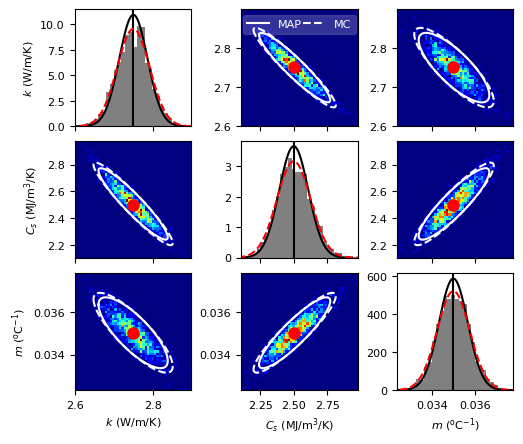

In [91]:
n_params = 3
labels = [r'$k\ \mathrm{(W/m/K)}$', r'$C_s\ \mathrm{(MJ/m^3/K)}$', r'$m\ \mathrm{(^oC^{-1})}$']

fig, axes = plt.subplots(n_params, n_params, figsize=(13/2.54, 11/2.54), constrained_layout=True,sharex='col',)

for i in range(n_params):
    for j in range(n_params):
        ax = axes[i, j]
        
        if i == j:
            # Diagonal: show histogram of each parameter
            
            ax.axvline(m_true[i], color='k')
            mu = m_true[i]
            sigma = np.sqrt(Cm_etrt[i,i])
            sigma_mc = np.sqrt(C_mc[i,i])
            x = np.linspace(mu - 4*sigma, m_true[i] + 4*sigma, 200)
            x_mc = np.linspace(mu - 4*sigma_mc, m_true[i] + 4*sigma_mc, 200)
            # Compute Gaussian (normal) PDF
            y = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma)**2)
            y_mc = (1 / (sigma_mc * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x_mc - mu) / sigma_mc)**2)
            ax.plot(x, y, 'k-', label='MAP')
            ax.plot(x_mc, y_mc, 'r--', label='MC')
            ax.hist(m_mc[:, i], bins=30, color='grey', density=True)
            
        else:
            # Off-diagonal: show 2D histogram + ellipse
            
            ax.hist2d(m_mc[:, j], m_mc[:, i], bins=(50, 50), cmap=plt.cm.jet)
            cov_nq = Cm_etrt[[j, i], :][:, [j, i]]
            cov_mc = C_mc[[j, i], :][:, [j, i]]
            mean = np.mean(m_mc, axis=0)[[j, i]]
            covariance_ellipse(cov_mc, mean, ax=ax, style='--w')
            covariance_ellipse(cov_nq, mean, ax=ax, style='-w')
            ax.plot(m_true[j], m_true[i], 'ro', markersize=8)
            
        # Set labels only on the left and bottom plots
        if i == n_params - 1:
            ax.set_xlabel(labels[j])
        if j == 0:
            ax.set_ylabel(labels[i])
            
import matplotlib.lines as mlines
handle_mc = mlines.Line2D([], [], color='white', linestyle='-', label='MAP')
handle_nq = mlines.Line2D([], [], color='white', linestyle='--', label='MC')

axes[0, 1].legend(handles=[handle_mc, handle_nq], loc='upper center', framealpha=0.2, labelcolor='white', ncol=2, columnspacing=0.1)

plt.show()

The MAP confidence intervals underestimate approximately by 15 % the Monte-Carlo confidence intervals, which takes into account non-linearity.

# 4. Visualisation of the cost function space

The misfit is computed for different combinations of the thermal parameters across a grid to visualize the cost function space.


In [92]:
# grid search parameters
mg = np.linspace(0.0324, 0.0376, 30)
kg = np.linspace(2.25, 3.25, 30)
# the grid is densified for C to improve resolution
Cg = np.linspace(2, 3, 30)
Cg = np.sort(np.concatenate([Cg, (Cg[:-1] + Cg[1:]) / 2]))

We run the grid search. Warning ! Fully running it will take several hours. It is recommended to use the saved files.

In [93]:
def run_grid_search(use_Saved_files=True):
    
    dir = "01-Synthetic_data/02-Grid_search"
    
    if use_Saved_files:
        files = sorted([f for f in os.listdir(dir) if f.endswith(".npy")])
        data = [np.load(os.path.join(dir, f)) for f in files]

        return data
    
    print('Warning ! Running grid search')

    data = []
    for mm in mg:
        dm = []
        for cc in Cg:
            for kk in kg:
                d = simulate_etrt(kk, cc, q, mm, sigma_ref, rBH,
                                  t_ERT, t_TRT, mesh, survey, simulation,
                                  getJ=False,
                                  sigma_water=sigmaw_ref,
                                  thermal_model='ICS', type='abs').ravel()
                dm.append(d)
                
        dm = np.array(dm)
        
        fname = f"grid_m{mm:.5f}.npy"
        np.save(os.path.join(dir, fname), dm)

        data.append(dm)
    
    return data

data_grid = run_grid_search()

In [94]:
# extract the data

nR = (len(t_ERT)) * len(zrec)
ndR = (len(t_ERT[1:]) ) * len(zrec)

diffR = []      # difference in apparent resistivity (Ohm-m)
diffT = []       # difference in temperature (degC)

for i in range(len(data_grid)):
    
    dR_all = np.zeros((data_grid[0].shape[0], ndR))
    dT_all = np.zeros((data_grid[0].shape[0], len(t_TRT)))
    
    for j in range(len(data_grid[i])):
        
        d = data_grid[i][j]
        
        Rj = d[:nR].reshape((len(t_ERT), len(zrec)))
        dR = Rj[1:] - Rj[0]
        
        
        dT = d[nR:]
        
        dR_all[j] = dR.flatten()
        dT_all[j] = d[nR:]
        
    
    diffR.append(dR_all)
    diffT.append(dT_all)

dR_true = data[:ndR]
dT_true = data[ndR:]

The misfit is computed.

In [95]:
phi = {'chi2' : [], 'chi2_R' : [], 'chi2_T' : [], 'p(m|dR,dT)':[], 'p(m|dT)':[]}
    
nR = len(t_ERT[1:]) * len(zrec)
cov = get_Cdi(t_ERT[1:], t_TRT, zrec)
covR = cov[:nR, :nR]
covT = cov[nR:, nR:]
    
for i in range(len(mg)):

    d = np.concatenate((dR_true.T, dT_true.T))
    dmod= np.concatenate((diffR[i].T, diffT[i].T))
    r = dmod - d.T[:, np.newaxis]
    rT = diffT[i].T - dT_true[:, np.newaxis]
    rR = diffR[i].T - dR_true[:, np.newaxis]


    phi['chi2'].append(np.einsum('ij,ij->j', r, cov @ r).reshape(len(Cg), len(kg)))
    phi['chi2_R'].append(np.einsum('ij,ij->j', rR, covR @ rR).reshape(len(Cg), len(kg)))
    phi['chi2_T'].append(np.einsum('ij,ij->j', rT, covT @ rT).reshape(len(Cg), len(kg)))             
        
all_chi2 = np.stack(phi['chi2'], axis=0)
global_min_chi2 = np.min(all_chi2)
    
all_chi2T = np.stack(phi['chi2_T'], axis=0)
global_min_chi2T = np.min(all_chi2T)
    
phi['p(m|dR,dT)'] = []
phi['p(m|dT)'] = []

for chi2_vals in phi['chi2']:
    chi2_shifted = chi2_vals - global_min_chi2
    likelihood = np.exp(-0.5 * chi2_shifted)
    phi['p(m|dR,dT)'].append(likelihood)
    
for chi2T_vals in phi['chi2_T']:
    chi2T_shifted = chi2T_vals - global_min_chi2T
    likelihoodT = np.exp(-0.5 * chi2T_shifted)
    sT = likelihoodT.sum()
    phi['p(m|dT)'].append(likelihoodT / sT if sT > 0 and np.isfinite(sT) else np.zeros_like(likelihoodT))
    
# stack into a 3D array: shape (n_m, n_C, n_k)
cube = np.stack(phi['p(m|dR,dT)'], axis=0)
cube /= cube.sum()
phi['p(m|dR,dT)'] = [cube[i] for i in range(cube.shape[0])]

## Plot the cost function

The cost function is plotted on the grid to obtain the confidence regions. We obtain 95 % confidence region ellipsoid following :
-  R. C. Aster, B. Borchers et C. H. Thurber, Parameter Estimation and Inverse Problems,
3rd ed. Elsevier, 2018.

For a multivariate normal distribution, the mistfit should follow a chi-squared distribution with $n$ degrees of freedom, where $n$ is the number of parameters ($n$ = 2 for TRT and $n$ = 3 for E-TRT). The 95 % confidence region is then obtained by the isocountour of the 95th percentile of the $\chi^2$ distribution $\Delta^2$, given by
$$
\Phi(\mathbf{m}) \leq \Phi(\mathbf{m_{est}}) + \Delta^2
$$
where $\mathbf{m_{est}}$ are the estimated model parameters.

In [96]:
from etrt.grid_fun import plot_sum_across_slices

In [97]:
from scipy.stats import chi2
iso95 = chi2.ppf(0.95, 3)
print(iso95)

7.814727903251179


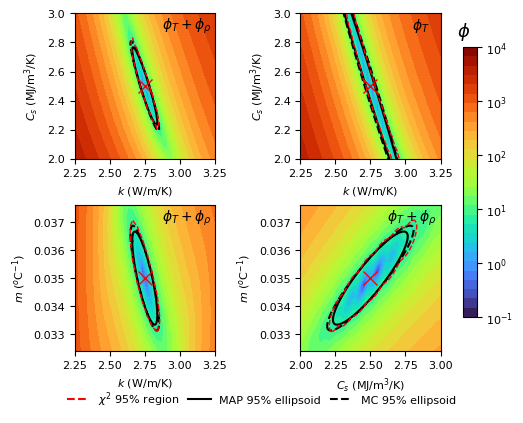

In [100]:
fig, ax = plt.subplots(2, 2, figsize=(13/2.54, 10/2.54), constrained_layout=True)

ax = ax.flatten()

# add covariance ellipses

covariance_ellipse(C_mc_trt[:2, :2], [k, C], ax=ax[1], style='k--')
covariance_ellipse(C_mc[:2, :2], [k, C], ax=ax[0], style='k--')
covariance_ellipse(C_mc[[0,2]][:,[0,2]], [k, m], ax=ax[2], style='k--')
covariance_ellipse(C_mc[[1,2]][:,[1,2]], [C, m], ax=ax[3], style='k--')

covariance_ellipse(Cm_etrt[:2, :2], [k, C], ax=ax[0], style='k-')
covariance_ellipse(Cm_trt[:2, :2], [k, C], ax=ax[1], style='k-')
covariance_ellipse(Cm_etrt[[0,2]][:,[0,2]], [k, m], ax=ax[2], style='k-')
covariance_ellipse(Cm_etrt[[1,2]][:,[1,2]], [C, m], ax=ax[3], style='k-')

# plot cost function across 3 planes
planes = ['Ck', 'Ck_T', 'km', 'Cm']
for idx, a in enumerate(ax):
    cf = plot_sum_across_slices(a, phi,
                                Rtype='chi2', Ttype='chi2_T',
                                kk=kg, CC=Cg, mm=mg, iso_levels=[iso95],
                                plane=planes[idx], vmin=0.1, vmax=1e4, sumcost=False, log=True)

ax[0].set_xlabel('$k$ (W/m/K)')
ax[0].set_ylabel('$C_s$ (MJ/m$^3$/K)')
ax[1].set_xlabel('$k$ (W/m/K)')
ax[1].set_ylabel('$C_s$ (MJ/m$^3$/K)')
ax[2].set_xlabel('$k$ (W/m/K)')
ax[2].set_ylabel('$m$ ($^o$C$^{-1}$)')
ax[3].set_xlabel('$C_s$ (MJ/m$^3$/K)')
ax[3].set_ylabel('$m$ ($^o$C$^{-1}$)')

ax[0].text(0.62, 0.98, "$\\phi_T + \\phi_\\rho$", color='black',transform=ax[0].transAxes, weight='bold', va='top', fontsize=10)
ax[1].text(0.80, 0.98, "$\\phi_T$", color='black',transform=ax[1].transAxes, weight='bold', va='top', fontsize=10)
ax[2].text(0.62, 0.98,  "$\\phi_T + \\phi_\\rho$", color='black',transform=ax[2].transAxes, weight='bold', va='top', fontsize=10)
ax[3].text(0.62, 0.98,  "$\\phi_T + \\phi_\\rho$", color='black',transform=ax[3].transAxes, weight='bold', va='top', fontsize=10)

ax[0].set_ylim(2, 3)
ax[1].set_ylim(2, 3)
ax[2].set_ylim(mg[0], mg[-1])
ax[3].set_ylim(mg[0], mg[-1])
ax[0].set_xlim(2.25, 3.25)
ax[1].set_xlim(2.25, 3.25)
ax[2].set_xlim(2.25, 3.25)

# add true model
mtrue = np.r_[k, C, m]
ax[0].plot(mtrue[0], mtrue[1], marker='x', markersize=10, color='red')
ax[1].plot(mtrue[0], mtrue[1], marker='x', markersize=10, color='red')
ax[2].plot(mtrue[0], mtrue[2], marker='x', markersize=10, color='red')
ax[3].plot(mtrue[1], mtrue[2], marker='x', markersize=10, color='red')

# colorbar
cbar = fig.colorbar(cf, ax=ax, location='right', shrink=0.8, pad=0.01, orientation='vertical', ticks=[1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4])
cbar.ax.text(0, 1.1, '$\\phi$',va='top', ha='center',transform=cbar.ax.transAxes, fontsize=13)

# legend
field_handle, = ax[0].plot([], [], '--r', label=r'$\chi^2$ 95% region')
field_handle, = ax[0].plot([], [], '-k', label=r'MAP 95% ellipsoid')
field_handle, = ax[0].plot([], [], '--k', label=r'MC 95% ellipsoid') 
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels,
           loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.05), labelspacing=0.01, columnspacing=0.8, frameon=False)

Some conclusions
- The E-TRT 95 % isocontour of the cost function matches well the 95 % confidence ellipsoid from MAP and Monte-Carlo.
- The TRT MAP and 95 % isocontour slightly underestimate the error on $k$ compare to the Monte-Carlo.
- The MAP provides an adequate estimation of the uncertainty

## Plot posterior distribution

The grid search also allows to directly calculate the posterior  distribution, by normalising the sum over the grid to 1. From $p(m|d)$, we can obtain
- The MAP, corresponding to the maximum value of $p(m|d)$
- The mean model, corresponding to the expectation value of $p(m|d)$
- The marginal distribution, corresponding to the integral of $p(m|d)$ over one parameter
- The confidence interval, corresponding to the interval containing 95 % of the cumulative density distribution of the marginals

The function `grid_fun.plot_prob` computes all these statistics and plots the posterior distribution for different 2D planes.

In [101]:
from etrt.grid_fun import plot_prob

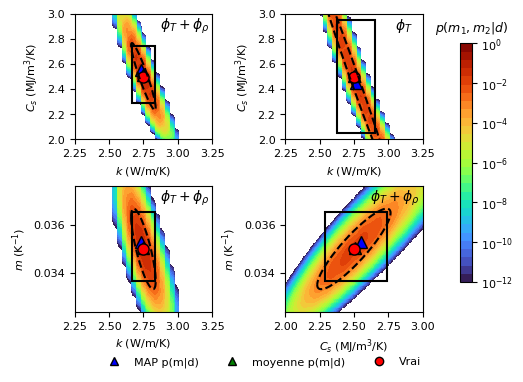

In [103]:
from matplotlib import lines as mlines
from matplotlib import patches

fig, ax = plt.subplots(2, 2, figsize=(13/2.54, 9/2.54), constrained_layout=True)

planes = ['Ck', 'Ck_T', 'km', 'Cm']
stats_all = {}

for idx, a in enumerate(ax.flatten()):
    cf, stats_all = plot_prob(
        a, phi,
        Rtype='p(m|dR,dT)', Ttype='p(m|dT)',
        kk=kg, CC=Cg, mm=mg,
        plane=planes[idx],
        vmin=1e-12, vmax=1,
    )
    if planes[idx] == "Ck_T":
        stats = stats_all["TRT"]
    else:
        stats = stats_all["E-TRT"]   

    ci = stats["confidence_intervals"]
    MAP = stats["MAP"]
    mean = stats["mean"]
    
    # Add confidence interval bounding box
    if planes[idx] == "Ck":
        xlow, xhigh = ci["k"]; ylow, yhigh = ci["C"]
        a.add_patch(patches.Rectangle((xlow, ylow), xhigh-xlow, yhigh-ylow,
                                      linewidth=1.5, edgecolor='black', facecolor='none', linestyle='-'))
        a.plot(MAP[1], MAP[0], marker='^', color='k', label='MAP', markerfacecolor='blue')
        a.plot(mean[1], mean[0], marker='^', color='k', label='Mean', markerfacecolor='green')
        a.plot(k, C, marker='o', color='k', label='True value', markerfacecolor='red')

    elif planes[idx] == "Ck_T":
        xlow, xhigh = ci["k"]; ylow, yhigh = ci["C"]
        a.add_patch(patches.Rectangle((xlow, ylow), xhigh-xlow, yhigh-ylow,
                                      linewidth=1.5, edgecolor='black', facecolor='none', linestyle='-'))
        a.plot(MAP[1], MAP[0], marker='^', color='k', label='MAP', markerfacecolor='blue')
        a.plot(mean[1], mean[0], marker='^', color='k', label='Mean', markerfacecolor='green')
        a.plot(k, C, marker='o', color='k', label='True value', markerfacecolor='red')

    elif planes[idx] == "km":
        xlow, xhigh = ci["k"]; ylow, yhigh = ci["m"]
        a.add_patch(patches.Rectangle((xlow, ylow), xhigh-xlow, yhigh-ylow,
                                      linewidth=1.5, edgecolor='black', facecolor='none', linestyle='-'))
        a.plot(MAP[1], MAP[2], marker='^', color='k', label='MAP', markerfacecolor='blue')
        a.plot(mean[1], mean[2], marker='^', color='k', label='Mean', markerfacecolor='green')
        a.plot(k, m, marker='o', color='k', label='True value', markerfacecolor='red')

    elif planes[idx] == "Cm":
        xlow, xhigh = ci["C"]; ylow, yhigh = ci["m"]
        a.add_patch(patches.Rectangle((xlow, ylow), xhigh-xlow, yhigh-ylow,
                                      linewidth=1.5, edgecolor='black', facecolor='none', linestyle='-'))
        a.plot(MAP[0], MAP[2], marker='^', color='k', label='MAP', markerfacecolor='blue')
        a.plot(mean[0], mean[2], marker='^', color='k', label='Mean', markerfacecolor='green')
        a.plot(C, m, marker='o', color='k', label='True value', markerfacecolor='red')

ax = ax.flatten()

ax[0].set_xlabel('$k$ (W/m/K)')
ax[0].set_ylabel('$C_s$ (MJ/m$^3$/K)')
ax[1].set_xlabel('$k$ (W/m/K)')
ax[1].set_ylabel('$C_s$ (MJ/m$^3$/K)')
ax[2].set_xlabel('$k$ (W/m/K)')
ax[2].set_ylabel('$m$ (K$^{-1}$)')
ax[3].set_xlabel('$C_s$ (MJ/m$^3$/K)')
ax[3].set_ylabel('$m$ (K$^{-1}$)')

ax[0].text(0.62, 0.98, "$\\phi_T + \\phi_\\rho$", color='black',transform=ax[0].transAxes, weight='bold', va='top', fontsize=10)
ax[1].text(0.80, 0.98, "$\\phi_T$", color='black',transform=ax[1].transAxes, weight='bold', va='top', fontsize=10)
ax[2].text(0.62, 0.98,  "$\\phi_T + \\phi_\\rho$", color='black',transform=ax[2].transAxes, weight='bold', va='top', fontsize=10)
ax[3].text(0.62, 0.98,  "$\\phi_T + \\phi_\\rho$", color='black',transform=ax[3].transAxes, weight='bold', va='top', fontsize=10)

covariance_ellipse(Cm_etrt[:2, :2], [k, C], ax=ax[0], style='k--')
covariance_ellipse(Cm_trt[:2, :2], [k, C], ax=ax[1], style='k--')
covariance_ellipse(Cm_etrt[[0,2]][:,[0,2]], [k, m], ax=ax[2], style='k--')
covariance_ellipse(Cm_etrt[[1,2]][:,[1,2]], [C, m], ax=ax[3], style='k--')

# colorbar
cbar = fig.colorbar(cf, ax=ax, location='right', shrink=0.8, pad=0.01,
                    orientation='vertical', ticks=[1e-12, 1e-10, 1e-8, 1e-6, 1e-4, 1e-2, 1e0])
cbar.ax.text(1, 1.1, '$p(m_1, m_2|d)$', va='top', ha='center', transform=cbar.ax.transAxes, fontsize=9)


ax[1].set_ylim(2, 3)
handles = mlines.Line2D([], [], color='k',  label='Ellipse MAP',)
handles = mlines.Line2D([], [], color='k',  label='Ellipse MAP',)
marker_MAP = mlines.Line2D([], [], color='k', marker='^', linestyle='None', markersize=6, markerfacecolor='blue', label='MAP p(m|d)')
marker_MEAN = mlines.Line2D([], [], color='k', marker='^', linestyle='None',markersize=6, markerfacecolor='green', label='moyenne p(m|d)')
marker_INV = mlines.Line2D([], [], color='k', marker='o', linestyle='None',markersize=6, markerfacecolor='red', label='Vrai')


fig.legend(handles=[marker_MAP, marker_MEAN, marker_INV],
           loc='lower center', bbox_to_anchor=(0.5, -0.05),
           ncol=3, fontsize=8, framealpha=0)

The resulting statistics :

In [104]:
for name, stats in stats_all.items():
    print(f"\nResults for {name}:")
    print("  MAP estimate:", np.round(stats["MAP"], 5))
    print("  Posterior mean:", np.round(stats["mean"], 5))
    print("  Confidence intervals:")
    for param, ci in stats["confidence_intervals"].items():
        low, high = ci 
        half_width = (high - low) / 2 
        print(f"{param:<10} : [{low:.5f}, {high:.5f}] (±{half_width:.5f})")


Results for E-TRT:
  MAP estimate: [2.55172 2.73276 0.03527]
  Posterior mean: [2.50929 2.74816 0.03505]
  Confidence intervals:
C          : [2.29310, 2.74138] (±0.22414)
k          : [2.66379, 2.83621] (±0.08621)
m          : [0.03366, 0.03652] (±0.00143)

Results for TRT:
  MAP estimate: [2.44828 2.76724]
  Posterior mean: [2.50594 2.75229]
  Confidence intervals:
C          : [2.05172, 2.94828] (±0.44828)
k          : [2.62931, 2.90517] (±0.13793)


In [105]:
print("\nComparison with MAP confidence intervals")

param_names = ["k", "C", "m"]

print("E-TRT:")
for name, val in zip(param_names, conf_etrt):
    print(f"    {name}: {val:.5f}")
    
print("TRT:")
for name, val in zip(param_names, conf_trt):
    print(f"    {name}: {val:.5f}")


Comparison with MAP confidence intervals
E-TRT:
    k: 0.07142
    C: 0.21345
    m: 0.00133
TRT:
    k: 0.20591
    C: 0.63583


Some conclusions
- The MAP and mean estimates are close to the true values, and the divergence may be explained by the resolution of the grid.
- The E-TRT confidence intervals obtained from the posterior are close to those obtained from the MAP, confirming the validity of the linear approximation.
- The TRT confidence intervals obtained from the posterior greatly underestimate those obtained from the MAP. This is because by normalizing the sum over the grid to 1, we implicitly assume a uniform prior over the grid.
- The posterior confirms that the MAP is good approximation for the E-TRT uncertainty.

# 5. Parameter estimation sensitivity

In this section, we wish to assess the effect of varying survey parameters on parameter recovery, such as :
- The number of electrodes
- The spacing between electrodes
- The temporal frequency of electrical measurements
- The survey duration

## Influence on the shape of the cost function for the ($C_s, k$) plane

We run the grid only along the ($C_s$, $k$) plane with m fixed at the true value for a more extensive survey (the full dataset). The goal is to see the effect of different parameters on the cost function space, hence on parameter recovery.

In [106]:
# parameter evaluation
kg2 = np.linspace(2, 5, 61) 
Cg2 = np.linspace(1.5, 3.50, 61)

We oversample the ERT and TRT timesteps until 10 days and chose a denser electrode spacing, from 5 cm to 4 m

In [107]:
times_trt_full = np.arange(12, 10 * 24 + 0.01, 10/60)
times_ert_full = np.hstack([0.0, np.arange(12, 10*24 + 0.01, 2)])
zrec_full = np.arange(0.05, 4.05, 0.05)
_, simulation_full, survey_full = ert_setup(zrec_full)

We run the grid search

In [108]:
import glob

def run_CK_plane(use_saved_files=True, Cgrid=Cg2, kgrid=kg2):
    
    data_dir = "01-Synthetic_data/03-Grid_search_Ck_sensitivity"
    
    def stack_files(files):
        panels = []
        for path in files:
            arr = np.load(path)
            panels.append(arr)
        stacked = np.stack(panels, axis=0)
        return stacked  
    
    if use_saved_files :
        
        Ck = stack_files(sorted(glob.glob(os.path.join(data_dir, 'grid_Ck*'))))
        return Ck
    
    nd = survey.nD * len(times_ert_full) + len(times_trt_full)
    
    for cc in Cgrid:
        dm = []
        for kk in kgrid:
            d = simulate_etrt(kk, cc, q, m, sigma_ref, rBH, times_ert_full, times_trt_full,
                                  mesh, survey_full, simulation_full, getJ=False,
                                  sigma_water=sigmaw_ref, thermal_model='ICS').ravel()
            dm.append(d)
        np.save(os.path.join(data_dir, f"grid_Ck_sweep{cc}.npy"), dm)
        
    Ck = stack_files(sorted(glob.glob(os.path.join(data_dir, 'grid_Ck*'))))
    
    return Ck
    
Ck = run_CK_plane(use_saved_files=True)

And extract the data

In [109]:
def extract_from_cube(cube: np.ndarray,t_ert: np.ndarray,de: np.ndarray,t_fiber: np.ndarray, Rt, diffRt, diffTt) -> dict:
    """
    Extract resistivity and temperature variations from a 3D cube, shape : (n_m, n_C, n_data)

    Returns: dictionnary with keys 
    - 'diffR_s': (n_m, n_C, ndR) array of resistivity variations for each model and parameter combination
    - 'diffT_s': (n_m, n_C, nT) array of temperature variations for each model and parameter combination
    - 'T_s': (n_m, n_C, nT) array of temperature for each model and parameter combination
    - 'R_t': (n_tR, n_elec) array of reference resistivity data
    - 'diffR_t': (ndR,) array of reference resistivity variations
    - 'diffT_t': (nT,) array of reference temperature variations
    """

    n_m, n_C, n_data = cube.shape
    nR = len(t_ert) * len(de)
    ndR = (len(t_ert) - 1) * len(de)
    diffR_s = np.zeros((n_m, n_C, ndR))
    diffT_s = np.zeros((n_m, n_C, len(t_fiber)))
    T_s     = np.zeros((n_m, n_C, len(t_fiber)))

    for i in range(n_m):
        for j in range(n_C):
            d = cube[i, j, :]
            Rj = d[:nR].reshape((len(t_ert), len(de)))
            dR = Rj[1:] - Rj[0]
            T  = d[nR:]

            diffR_s[i, j, :] = dR.flatten()
            diffT_s[i, j, :] = T
            T_s[i, j, :]     = T

    return {
        'diffR_s': diffR_s,
        'diffT_s': diffT_s,
        'T_s': T_s,
        'R_t': Rt,
        'diffR_t': diffRt,
        'diffT_t': diffTt
    }

def mask_cube(cube: dict,tR: np.ndarray,tT: np.ndarray,de: np.ndarray, t_ert, zrec, t_fiber) -> dict:
    """
    Mask the grid search data dictionary with respect to ERT and TRT timesteps and electrode spacing

    Parameters:
    - cube: return dictionary from the extract_from_cube function
    - tR: ERT times to keep (excluding t=0)
    - tT: TRT times to keep
    - de: electrode spacings to keep
    - t_ert: full ERT timesteps
    - zrec: full electrode spacings
    - t_fiber: full TRT timesteps

    Returns:
    - Dictionary with masked data and reference  ERT and TRT timesteps and electrode spacing
    """
    
    # create mask
    mask_e = np.isin(zrec, de)
    mask_tR = np.isin(t_ert[1:], tR)
    mask_tRe = np.isin(t_ert, np.concatenate([[0], tR]))
    mask_tT = np.isin(t_fiber, tT)

    n1, n2, _ = cube['diffR_s'].shape
    n_tR = len(t_ert[1:])
    n_elec = len(zrec)
    
    ndR_masked = np.sum(mask_tR) * np.sum(mask_e)
    nT_masked = np.sum(mask_tT)

    masked_R_cube = np.zeros((n1, n2, ndR_masked))
    masked_T_cube = np.zeros((n1, n2, nT_masked))

    # mask the two datasets
    
    for i in range(n1):
        for j in range(n2):
            d = cube['diffR_s'][i, j, :].reshape(n_tR, n_elec)
            dR_masked = d[mask_tR][:, mask_e].ravel()

            Tj = cube['diffT_s'][i, j, :]
            Tj_masked = Tj[mask_tT]

            masked_R_cube[i, j, :] = dR_masked
            masked_T_cube[i, j, :] = Tj_masked

    R_t_masked = cube['R_t'].reshape(len(t_ert), n_elec)[mask_tRe][:, mask_e]
    diffR_t_masked = cube['diffR_t'].reshape(n_tR, n_elec)[mask_tR][:, mask_e].flatten()
    diffT_t_masked = cube['diffT_t'][mask_tT]

    return {
        'diffR_s': masked_R_cube,
        'diffT_s': masked_T_cube,
        'R_t': R_t_masked,
        'diffR_t': diffR_t_masked,
        'diffT_t': diffT_t_masked,
        'tT': tT,
        'tR': tR,
        'de': de,
    }

We define the true model based on the known thermal parameters

In [110]:
# generate data for true parameters for these values
d_full = simulate_etrt(k, C, q, m, sigma_ref, rBH, times_ert_full, times_trt_full, mesh, survey_full, simulation_full, getJ=False, type='abs',
                          sigma_water=sigmaw_ref, thermal_model='ICS')

In [111]:
nR = len(zrec_full) * (len(times_ert_full))
ndR = len(zrec_full) * (len(times_ert_full) - 1)  
R_t = d_full[:nR].reshape((len(times_ert_full), len(zrec_full)))
diffR_t = d_full[:nR].reshape((len(times_ert_full), len(zrec_full))) - d_full[:len(zrec_full)].T
diffR_t = diffR_t[1:].flatten()
T_t = d_full[nR:]
diffT_t = d_full[nR:]

In [112]:
data = extract_from_cube(Ck, times_ert_full, zrec_full, times_trt_full, R_t, diffR_t, diffT_t)

We calculate the misfit grid for different cases with respect to the reference case. We also use a normalized misfit $\phi'$ ($\phi$ divided by the number of ERT data) to account for the different number of data in each case. This allows to compare the effect of different survey parameters on the global sensitivity of ERT to $k$ and $C_s$

In [113]:
def get_misfit_CK(d):
    """
    Compute the cost function value from the dictionnary returned by the mask_cube function, for each model and parameter combination. 

    Returns:
    - phi: dictionary of cost metrics
    """
    
    n1, n2, ndR = d['diffR_s'].shape
    _, _, nT = d['diffT_s'].shape

    # Initialize cost arrays
    phi = {
        'chi2': np.zeros((n1, n2)),
        'chi2T': np.zeros((n1, n2)),
        'chi2R': np.zeros((n1, n2)),
        'chi2T_norm': np.zeros((n1, n2)),
        'chi2R_norm': np.zeros((n1, n2)),
    }

    # Covariance matrix
    cov = get_Cdi(d['tR'], d['tT'], d['de'])
    covR = cov[:ndR, :ndR]
    covT = cov[ndR:, ndR:]

    for i in range(n1):
        for j in range(n2):
            R = d['diffR_s'][i, j, :]
            T = d['diffT_s'][i, j, :]

            dd = np.concatenate((d['diffR_t'], d['diffT_t'] ))
            dmod= np.concatenate((R, T))
            r = dmod - dd
            rT = T - d['diffT_t'] 
            rR = R - d['diffR_t']
            
            phi['chi2'][i, j] = (r.T @ cov @ r)
            
            phi['chi2R'][i, j] = (rR.T @ covR @ rR)
            phi['chi2R_norm'][i, j] = (rR.T @ covR @ rR)/ndR
            
            phi['chi2T'][i, j] = (rT.T @ covT @ rT)
            phi['chi2T_norm'][i, j] = (rT.T @ covT @ rT)/nT

    return phi

In [114]:
tR_ref = times_ert_full[1::2][:16]
tT_ref = times_trt_full[:361]
e_ref = zrec_full[4::5][:8]

print('Reference---------------------------\nERT frequency (h)', tR_ref,'\nLength (h)', tR_ref[-1], tT_ref[-1], '\nElectrode spacing (m)', e_ref)

d_ref = mask_cube(data, tR_ref, tT_ref, e_ref, times_ert_full, zrec_full, times_trt_full)
phi_ref = get_misfit_CK(d_ref)

print('Number of electrodes---------------------------\nMin', zrec_full[4::5][0],'\nMax', zrec_full[4::5])

d_Nemin = mask_cube(data, tR_ref, tT_ref, [zrec_full[4::5][0]], times_ert_full, zrec_full, times_trt_full)
d_Nemax = mask_cube(data, tR_ref, tT_ref, zrec_full[4::5], times_ert_full, zrec_full, times_trt_full)
phi_Nemin = get_misfit_CK(d_Nemin)
phi_Nemax = get_misfit_CK(d_Nemax)

print('Electrode spacing---------------------------\nMin', zrec_full[1::2][:20],'\nMax', zrec_full[19::20][:2])

d_demin = mask_cube(data, tR_ref, tT_ref, zrec_full[1::2][:20], times_ert_full, zrec_full, times_trt_full)
d_demax = mask_cube(data, tR_ref, tT_ref, zrec_full[19::20][:2], times_ert_full, zrec_full, times_trt_full)
phi_demin = get_misfit_CK(d_demin)
phi_demax = get_misfit_CK(d_demax)

print('Survey length---------------------------\nMin',times_ert_full[1::2][:4], times_trt_full[72],'\nMax',times_ert_full[1::2], times_trt_full[-1])

d_Lmin = mask_cube(data, times_ert_full[1::2][:4], times_trt_full[1:80], e_ref, times_ert_full, zrec_full, times_trt_full)
d_Lmax = mask_cube(data, times_ert_full[1::2], times_trt_full[1:1400], e_ref, times_ert_full, zrec_full, times_trt_full)
phi_Lmin = get_misfit_CK(d_Lmin)
phi_Lmax = get_misfit_CK(d_Lmax)

print('Frequency---------------------------\nMin',times_ert_full[1:32],'\nMax',times_ert_full[7::12][:3])

d_fmin = mask_cube(data,times_ert_full[1:31], tT_ref, e_ref, times_ert_full, zrec_full, times_trt_full)
d_fmax = mask_cube(data,times_ert_full[7::12][:3], tT_ref, e_ref, times_ert_full, zrec_full, times_trt_full)
phi_fmin = get_misfit_CK(d_fmin)
phi_fmax = get_misfit_CK(d_fmax)

Reference---------------------------
ERT frequency (h) [12. 16. 20. 24. 28. 32. 36. 40. 44. 48. 52. 56. 60. 64. 68. 72.] 
Length (h) 72.0 71.99999999999979 
Electrode spacing (m) [0.25 0.5  0.75 1.   1.25 1.5  1.75 2.  ]
Number of electrodes---------------------------
Min 0.25 
Max [0.25 0.5  0.75 1.   1.25 1.5  1.75 2.   2.25 2.5  2.75 3.   3.25 3.5
 3.75 4.  ]
Electrode spacing---------------------------
Min [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8
 1.9 2. ] 
Max [1. 2.]
Survey length---------------------------
Min [12. 16. 20. 24.] 23.999999999999957 
Max [ 12.  16.  20.  24.  28.  32.  36.  40.  44.  48.  52.  56.  60.  64.
  68.  72.  76.  80.  84.  88.  92.  96. 100. 104. 108. 112. 116. 120.
 124. 128. 132. 136. 140. 144. 148. 152. 156. 160. 164. 168. 172. 176.
 180. 184. 188. 192. 196. 200. 204. 208. 212. 216. 220. 224. 228. 232.
 236. 240.] 239.9999999999992
Frequency---------------------------
Min [12. 14. 16. 18. 20. 22. 24. 26. 28. 30. 32. 34.

We plot the normalized misfit $\phi'$ for the different cases. We add two isocontours, one for $\phi'$ = 1, representing solutions that fit the data within its uncertainty, and one for the 95 % confidence region based on the chi2 distribution with 2 degrees of freedom.

In [115]:
def add_panel(ax, phi, Rtype, Ttype, x, y, isolevels, vmax, onlyT=False, onlyR=False, isocolor='red'):

    if onlyT:
        Z = phi[Ttype]
    elif onlyR:
        Z = phi[Rtype]
    else:
        Z = phi[Rtype] + phi[Ttype]

    X, Y = np.meshgrid(x, y)
    levels = np.linspace(0, vmax, 20)
    ax.contourf(X, Y, Z, cmap='turbo', levels=levels)
    cs = ax.contour(X, Y, Z, levels=isolevels, colors=isocolor, linewidths=1)
    
    return cs

def add_iso(ax, phi, Rtype, Ttype, x, y,isolevels, onlyT=False, onlyR=False):

    if onlyT:
        Z = phi[Ttype]
    elif onlyR:
        Z = phi[Rtype]
    else:
        Z = phi[Rtype] + phi[Ttype]

    X, Y = np.meshgrid(x, y)
    ax.contour(X, Y, Z, levels=isolevels, colors='red', linewidths=1)
    
    return 


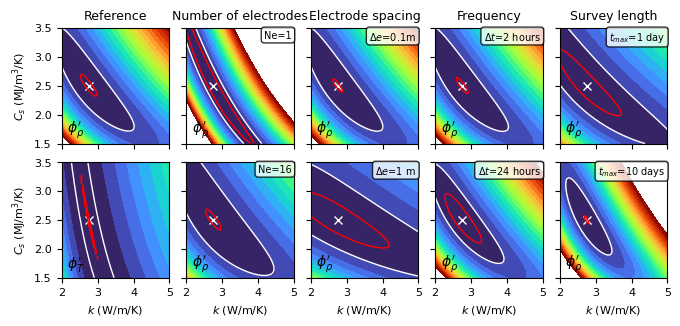

In [118]:
fig, ax = plt.subplots(2, 5, figsize=(17/2.54, 8/2.54), constrained_layout=True, sharex=True, sharey=True)

for a in ax.flatten():
    a.plot(k, C, marker='x', color='white', markersize=6)

Rtype_iso = 'chi2R'
Ttype = 'chi2T'
iso95 = [chi2.ppf(0.95, 2)]
add_iso(ax[0, 0], phi_ref, Rtype_iso, Ttype, kg2, Cg2, iso95, onlyR=True)
add_iso(ax[1, 0], phi_ref, Rtype_iso, Ttype, kg2, Cg2, iso95, onlyT=True)


Rtype = 'chi2R_norm'
Ttype = 'chi2T_norm'
iso = [1]
vmax = 20

# Reference
ax[0,0].set_title('Reference', fontsize=9)
add_panel(ax[0, 0], phi_ref, Rtype, Ttype, kg2, Cg2, iso, vmax=vmax, onlyR=True, isocolor='white')
add_panel(ax[1, 0], phi_ref, Rtype, Ttype, kg2, Cg2, iso, vmax=100, onlyT=True, isocolor='white')

# Number of electrodes
ax[0,1].set_title('Number of electrodes', fontsize=9)
ax[0, 1].text(0.98, 0.98, "Ne=1", ha='right', va='top', transform=ax[0,1].transAxes, fontsize=7, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
ax[1, 1].text(0.98, 0.98, "Ne=16", ha='right', va='top', transform=ax[1,1].transAxes, fontsize=7, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
add_panel(ax[0, 1], phi_Nemin, Rtype, Ttype, kg2, Cg2, iso, vmax=vmax, onlyR=True, isocolor='white')
add_panel(ax[1, 1], phi_Nemax, Rtype, Ttype, kg2, Cg2, iso, vmax=vmax, onlyR=True, isocolor='white')

# Electrode spacing
ax[0,2].set_title('Electrode spacing', fontsize=9)
ax[0, 2].text(0.98, 0.98, "$\\Delta e$=0.1m", ha='right', va='top', transform=ax[0,2].transAxes, fontsize=7, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
ax[1, 2].text(0.98, 0.98, "$\\Delta e$=1 m", ha='right', va='top', transform=ax[1,2].transAxes, fontsize=7, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
add_panel(ax[0, 2], phi_demin, Rtype, Ttype, kg2, Cg2, iso, vmax=vmax, onlyR=True, isocolor='white')
add_panel(ax[1, 2], phi_demax, Rtype, Ttype, kg2, Cg2, iso, vmax=vmax, onlyR=True, isocolor='white')

# Frequency
ax[0,3].set_title('Frequency', fontsize=9)
ax[0, 3].text(0.98, 0.98, "$\\Delta t$=2 hours", ha='right', va='top', transform=ax[0,3].transAxes, fontsize=7, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
ax[1, 3].text(0.98, 0.98, "$\\Delta t$=24 hours", ha='right', va='top', transform=ax[1,3].transAxes, fontsize=7, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
add_panel(ax[0, 3], phi_fmin, Rtype, Ttype, kg2, Cg2, iso, vmax=vmax, onlyR=True, isocolor='white')
add_panel(ax[1, 3], phi_fmax, Rtype, Ttype, kg2, Cg2, iso, vmax=vmax, onlyR=True, isocolor='white')

# Survey length
ax[0, 4].set_title('Survey length', fontsize=9)
ax[0, 4].text(0.98, 0.98, "$t_{max}$=1 day", ha='right', va='top', transform=ax[0,4].transAxes, fontsize=7, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
ax[1, 4].text(0.98, 0.98, "$t_{max}$=10 days", ha='right', va='top', transform=ax[1,4].transAxes, fontsize=7, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
add_panel(ax[0, 4], phi_Lmin, Rtype, Ttype, kg2, Cg2, iso, vmax=vmax, onlyR=True, isocolor='white')
add_panel(ax[1, 4], phi_Lmax, Rtype, Ttype, kg2, Cg2, iso, vmax=vmax, onlyR=True, isocolor='white')

add_iso(ax[0, 1], phi_Nemin, Rtype_iso, Ttype, kg2, Cg2, iso95, onlyR=True)
add_iso(ax[1, 1], phi_Nemax, Rtype_iso, Ttype, kg2, Cg2, iso95, onlyR=True)
add_iso(ax[0, 2], phi_demin, Rtype_iso, Ttype, kg2, Cg2, iso95, onlyR=True)
add_iso(ax[1, 2], phi_demax, Rtype_iso, Ttype, kg2, Cg2, iso95, onlyR=True)
add_iso(ax[0, 3], phi_fmin, Rtype_iso, Ttype, kg2, Cg2, iso95, onlyR=True)
add_iso(ax[1, 3], phi_fmax, Rtype_iso, Ttype, kg2, Cg2, iso95, onlyR=True)
add_iso(ax[0, 4], phi_Lmin, Rtype_iso, Ttype, kg2, Cg2, iso95, onlyR=True)
add_iso(ax[1, 4], phi_Lmax, Rtype_iso, Ttype, kg2, Cg2, iso95, onlyR=True)


# Axis labels
ax[0,0].set_ylabel('$C_s$ (MJ/m$^3$/K)')
ax[1,0].set_ylabel('$C_s$ (MJ/m$^3$/K)')
for i in range(5):
    ax[1,i].set_xlabel('$k$ (W/m/K)')

# Annotations
ax = ax.flatten()
pR = [0, 1, 2, 3, 4, 6, 7, 8, 9]
ax[5].text(0.05, 0.03, '$\\phi_T\'$', ha='left', va='bottom', transform=ax[5].transAxes, fontsize=10, color='black')
for i in pR:
    ax[i].text(0.05, 0.03, '$\\phi_\\rho\'$', ha='left', va='bottom', transform=ax[i].transAxes, fontsize=10, color='black')

plt.show()

## Influence on the confidence intervals

Now, we wish to evaluate the effect of different survey parameters on the confidence intervals of the estimated parameters.
We start by generating the data and the jacobian for the full dataset.

In [119]:
# generate data for true parameters for these values
d_full, J_full = simulate_etrt(k, C, q, m, sigma_ref, rBH, times_ert_full, times_trt_full, mesh, survey_full, simulation_full, getJ=True, type='diff',sigma_water=sigmaw_ref, thermal_model='ICS')

We create a function to mask the Jacobian and another function to obtain the confidence intervals

In [120]:
def mask_jacobian(d, J, tR, tT, de):    
    
    mask_e = np.isin(zrec_full, de)                   
    mask_tR = np.isin(times_ert_full[1:], tR)         
    mask_tT = np.isin(times_trt_full, tT)   

    d_ert = d[:len(times_ert_full[1:])*len(zrec_full)]
    d_trt = d[len(times_ert_full[1:])*len(zrec_full):]

    
    dd = d_ert.reshape(len(times_ert_full[1:]), len(zrec_full))
    d_ert_masked = dd[mask_tR][:, mask_e].ravel()
    d_trt_masked = d_trt[mask_tT]
    
    J_ert = J[:len(times_ert_full[1:])*len(zrec_full)]
    J_trt = J[len(times_ert_full[1:])*len(zrec_full):]
    
    j = J_ert.reshape(len(times_ert_full[1:]), len(zrec_full), -1)
    J_ert_masked = j[mask_tR][:, mask_e, :].reshape(-1, J.shape[1])
    
    J_trt_masked = J_trt[mask_tT]
    
    return np.r_[d_ert_masked, d_trt_masked], np.r_[J_ert_masked, J_trt_masked]

def get_conf(tR, tT, e, J):
    Jetrt = J
    Jtrt = Jetrt[len(tR)*len(e):, :]
    Jtrt = np.delete(Jtrt, -1, axis=1)
    
    c = get_Cdi(tR, tT, e)
    
    confR = 1.96 * np.sqrt(np.diag(np.linalg.inv(Jetrt.T @ c @ Jetrt)))/m_true * 100
    confT = 1.96 * np.sqrt(np.diag(np.linalg.inv(Jtrt.T @ c[-len(tT):, -len(tT):] @ Jtrt))) /m_true[:-1] * 100
    
    return np.r_[confR, confT]
    

The uncertainty is evaluated for ERT measurements from every 2 hours to 30 hours

In [121]:
Rtype='Rrmse'
iso = 0.09

freq = [times_ert_full[1:][:31], times_ert_full[1::2][:16], times_ert_full[1::3][:11], times_ert_full[1::5][:7], times_ert_full[1::6][:6], times_ert_full[1::10][:4], times_ert_full[1::15][:3]]


freq_label = []
for f in freq:
    if len(f) >= 2:
        freq_label.append((f[-1] - f[-2]))
    else:
        freq_label.append(f[-1])
    
phi_freq = []
conf_freq = []

for i in range(len(freq)):
    print('Selected time steps', freq[i])
    d = mask_cube(data, freq[i], tT_ref, e_ref, times_ert_full, zrec_full, times_trt_full)
    J = mask_jacobian(d_full, J_full, freq[i], tT_ref, e_ref)[1]
    conf_freq.append(get_conf(freq[i], tT_ref, e_ref, J))

conf_freq = np.array(conf_freq)

Selected time steps [12. 14. 16. 18. 20. 22. 24. 26. 28. 30. 32. 34. 36. 38. 40. 42. 44. 46.
 48. 50. 52. 54. 56. 58. 60. 62. 64. 66. 68. 70. 72.]
Selected time steps [12. 16. 20. 24. 28. 32. 36. 40. 44. 48. 52. 56. 60. 64. 68. 72.]
Selected time steps [12. 18. 24. 30. 36. 42. 48. 54. 60. 66. 72.]
Selected time steps [12. 22. 32. 42. 52. 62. 72.]
Selected time steps [12. 24. 36. 48. 60. 72.]
Selected time steps [12. 32. 52. 72.]
Selected time steps [12. 42. 72.]


The uncertainty is evaluated for survey lengths varying between 1 and 10 days

In [122]:
nb_days = np.arange(1, 11)  
tR = np.array(times_ert_full)
tT = np.array(times_trt_full)
lengthR = [tR[tR  < day*24 + .1] for day in nb_days]
lengthT = [tT[tT  < day*24 + .1] for day in nb_days]

phi_length = []
box_length = []
conf_length = []
for i in range(len(lengthR)):
    print('Length of E-TRT: ', lengthR[i][-1]/24, 'days')
    d = mask_cube(data, lengthR[i], tT_ref, e_ref, times_ert_full, zrec_full, times_trt_full)
    J = mask_jacobian(d_full, J_full, lengthR[i][1:], lengthT[i], e_ref)[1]
    conf_length.append(get_conf(lengthR[i][1:], lengthT[i], e_ref, J))

conf_length = np.array(conf_length)

Length of E-TRT:  1.0 days
Length of E-TRT:  2.0 days
Length of E-TRT:  3.0 days
Length of E-TRT:  4.0 days
Length of E-TRT:  5.0 days
Length of E-TRT:  6.0 days
Length of E-TRT:  7.0 days
Length of E-TRT:  8.0 days
Length of E-TRT:  9.0 days
Length of E-TRT:  10.0 days


The uncertainty is evaluated for keeping the same electrode spacing of 25 cm and varying the number of electrode pairs between 1 and 17 (meaning between 25 cm spacing to 4 meters spacing)

In [123]:
nb_electrodes = np.arange(1, 17)  
de = np.array(zrec_full[4::5])
electrodes = [de[:i] for i in nb_electrodes]

phi_electrodes = []
conf_electrodes = []
for i in range(len(nb_electrodes)):
    print('Number of electrodes :', len(electrodes[i]))
    d = mask_cube(data, tR_ref, tT_ref, electrodes[i], times_ert_full, zrec_full, times_trt_full)
    J = mask_jacobian(d_full, J_full, tR_ref, tT_ref, electrodes[i])[1]
    conf_electrodes.append(get_conf(tR_ref, tT_ref, electrodes[i], J))

conf_electrodes = np.array(conf_electrodes)

Number of electrodes : 1
Number of electrodes : 2
Number of electrodes : 3
Number of electrodes : 4
Number of electrodes : 5
Number of electrodes : 6
Number of electrodes : 7
Number of electrodes : 8
Number of electrodes : 9
Number of electrodes : 10
Number of electrodes : 11
Number of electrodes : 12
Number of electrodes : 13
Number of electrodes : 14
Number of electrodes : 15
Number of electrodes : 16


The uncertainty is evaluated for keeping the maximum reference spacing of 2 m and varying the electrode spacing between 5 cm and 1 m

In [124]:
spacing_index = [0.05, 0.1, 0.25, 0.4, 0.5, 1]  
s = np.array(zrec_full[:40])
spacing = [s[np.isin(s, np.round(np.arange(sp, 2.01, sp), 2))] for sp in spacing_index]

phi_spacing = []
conf_spacing = []
for i in range(len(spacing_index)):
    print('Electrodes', spacing[i])
    d = mask_cube(data,tR_ref, tT_ref, spacing[i], times_ert_full, zrec_full, times_trt_full)
    J = mask_jacobian(d_full, J_full, tR_ref, tT_ref, spacing[i])[1]
    conf_spacing.append(get_conf(tR_ref, tT_ref, spacing[i], J))

conf_spacing = np.array(conf_spacing)

Electrodes [0.05 0.1  0.2  0.25 0.3  0.4  0.45 0.5  0.55 0.8  1.   1.05 1.1  1.3
 1.35 1.55 1.6  1.8  1.85 2.  ]
Electrodes [0.1 0.2 0.3 0.4 0.5 0.8 1.  1.1 1.3 1.6 1.8 2. ]
Electrodes [0.25 0.5  1.   2.  ]
Electrodes [0.4 0.8 1.6 2. ]
Electrodes [0.5 1.  2. ]
Electrodes [1. 2.]


Finally we also evaluate the effect of the measurements uncertainty on the heat injection rate $q$ on the thermal parameters uncertainty. $q$ is incorporated into the data with an associated measurement uncertainty.

In [125]:
def get_conf_q(tR, tT, e, J, sigmaq):
    Jetrt = J
    Jtrt = Jetrt[len(tR)*len(e):, :]
    Jtrt = np.delete(Jtrt, -1, axis=1)
    
    c = get_Cdi(tR, tT, e, sigma_q = sigmaq)
    
    confR = 1.96 * np.sqrt(np.diag(np.linalg.inv(Jetrt.T @ c @ Jetrt)))/np.r_[k, C, q, m] * 100
    confT = 1.96 * np.sqrt(np.diag(np.linalg.inv(Jtrt.T @ c[-len(tT)-1:, -len(tT)-1:] @ Jtrt))) /np.r_[k, C, q] * 100
    
    return confR, confT

In [126]:
_, J_full_q = simulate_etrt(k, C, q, m, sigma_ref, rBH, t_ERT, t_TRT, mesh, survey, simulation, getJ=True, type='diff', thermal_model='ICS', param_q=True)

sigmaqs = np.geomspace(0.001, 0.1, 50) * q
conf_trts = []
conf_etrts = []

for i, sigmaq in enumerate(sigmaqs):
    conf = get_conf_q(tR_ref, tT_ref, e_ref, J_full_q, sigmaq)
    conf_trts.append(conf[1][:-1])
    conf_etrts.append(np.r_[conf[0][:2], conf[0][-1]])
    
conf_trts = np.array(conf_trts)
conf_etrts = np.array(conf_etrts)

We plot the resulting confidence intervals in one figure

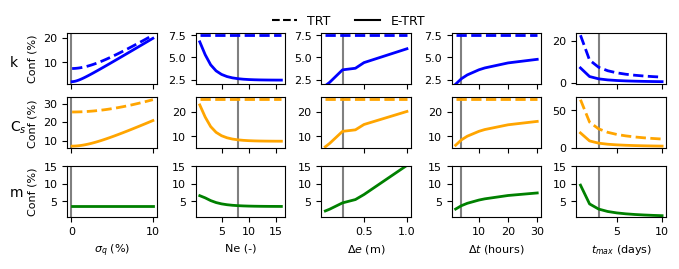

In [128]:
color = ['blue', 'orange', 'green']
def plot_confidence_comparison(ax, c, label, conf, param_indices=[0, 1, 2]):
    for i in range(3):
        
        if i==2:
            ax[i, c+1].plot(label, conf[:, i], color=color[i], linewidth=2)
        else :
            ax[i, c+1].plot(label, conf[:, param_indices[i]], color=color[i], linewidth=2)
            ax[i, c+1].plot(label, conf[:, param_indices[i] + 3], color=color[i], linestyle='--', linewidth=2)

fig, ax = plt.subplots(3, 5, figsize=(16.5/2.54, 6/2.54), constrained_layout=True, gridspec_kw={'hspace': 0.001, 'wspace': 0.05})

for i in range(3):
    ax[i, 0].axvline(0, color='grey')
    ax[i, 1].axvline(8, color='grey')
    ax[i, 2].axvline(0.25, color='grey')
    ax[i, 3].axvline(4, color='grey')
    ax[i, 4].axvline(3, color='grey')

for c, conf in enumerate([conf_electrodes, conf_spacing, conf_freq, conf_length]):
    plot_confidence_comparison(ax, c, [nb_electrodes, spacing_index, freq_label, nb_days][c], conf)
    
for i, p in enumerate([0, 1, 2]):
    
    if p==2:
        ax[i, 0].plot(sigmaqs/q*100, conf_etrts[:,p], '-', color=color[i], linewidth=2)
    else:
        ax[i, 0].plot(sigmaqs/q*100, conf_trts[:,p], '--', color=color[i], linewidth=2)
        ax[i, 0].plot(sigmaqs/q*100, conf_etrts[:,p], '-', color=color[i], linewidth=2)
    
ax[0, 0].set_ylabel('Conf (%)')
ax[1, 0].set_ylabel('Conf (%)')
ax[2, 0].set_ylabel('Conf (%)')

for i in range(5):
    ax[0, i].tick_params(axis='x', labelbottom=False)
    ax[1, i].tick_params(axis='x', labelbottom=False)
    ax[2, i].set_ylim(0.5, 15)
    
for i in range(3):
    ax[0, i+1].set_ylim(2, 7.75)
    ax[1, i+1].set_ylim(5, 26)
    
fig.text(-0.021, 0.85, 'k', va='center', fontsize=10)
fig.text(-0.021, 0.575, r'C$_s$', va='center', fontsize=10)
fig.text(-0.021, 0.3, 'm', va='center', fontsize=10)

ax[2, 0].set_xlabel('$\\sigma_q$ (%)')
ax[2, 1].set_xlabel('Ne (-)')
ax[2, 2].set_xlabel('$\\Delta e$ (m)')
ax[2, 3].set_xlabel('$\\Delta t$ (hours)')
ax[2, 4].set_xlabel('$t_{max}$ (days)')

from matplotlib.lines import Line2D

# Define custom legend handles
legend_elements = [
    Line2D([0], [0], color='black', linestyle='--', label='TRT'),
    Line2D([0], [0], color='black', linestyle='-', label=r'E-TRT'),
]

# Add legend to the top of the figure
fig.legend(handles=legend_elements,loc='upper center',bbox_to_anchor=(0.5, 1.1), ncol=2, fontsize=9, frameon=False)


## Sensitivity to water and rock electrical properties

In this section, we examine how sensitive the E-TRT survey is to variations in the electrical properties of both the rock and the pore water. These parameters influence only the ERT component of the data. 
 
Starting from the reference case, we generate the E-TRT data for different combinations of $C_s$ and $k$, while keeping $m$ at its true value for two rock resistivity (10 and 10000 Ohm-m) and four water-to-rock resistivity ratio (1/1, 1/10, 1/100 and 1/1000). We then compute the ERT normalized misfit $\phi_\rho'$ grid for each case.

Because the goal is to assess the influence of the electrical properties, we use a coarser grid and reduce the number of $C_s$ samples.

In [129]:
Cg3 = np.linspace(1.5, 3.50, 21)  

We run the grid search for the 8 cases.

In [130]:
dir = "01-Synthetic_data/04-Grid_search_Ck_rho"
import re

def run_water_rock_ratio(use_Saved_files=True, Cgrid=Cg3, kgrid=kg2):
    
    if use_Saved_files:
        
        d = {}
        
        for fname in os.listdir(dir):
            match = re.match(r"rhoR([\d.]+)_rhoW([\d.]+)\.npy", fname)
            if match:
                rhoR = float(match.group(1))
                rhoW = float(match.group(2))
                key = (rhoR, rhoW)
                    
                d[key] = np.load(os.path.join(dir, fname))
        return d
    
    rho_rock_values = [10, 100, 1000, 10000]
    ratios = [1, 10, 100, 1000]
    
    for rock_index, rho_rock in enumerate(rho_rock_values):
        for ratio_index, ratio in enumerate(ratios):
            rho_w = rho_rock / ratio
            
            dm = []
            for cc in Cgrid:
                for kk in kgrid:
                    d = simulate_etrt(kk, cc, q, m, sigma_ref, rBH, times_ert_full, times_trt_full, mesh, survey, simulation, getJ=False,
                                          sigma_water=1/rho_w, thermal_model='ICS')
                    dm.append(d)
                
            dm = np.array(dm)
            np.save(os.path.join(dir, f"rhoR{rho_rock:.2f}_rhoW{rho_w}.npy"), dm)
            
    return run_water_rock_ratio(use_Saved_files=True)

rock_rho = run_water_rock_ratio(use_Saved_files=True)

The data is extracted and the normalized misfit $\phi_\rho'$ is computed for each case.

In [131]:
ndR = len(t_ERT[1:]) * len(zrec)
nR = len(t_ERT) * len(zrec)
nC, nk = len(Cg3), len(kg2)

phi_Rroc_Rw = {}

for (rho_rock, rho_w), m_rw in rock_rho.items():
    print(f"Rock resistivity: {rho_rock} Ohm-m, Water resistivity: {rho_w} Ohm-m")
    
    # Initialize cube arrays
    diffR_cube = np.zeros((nC, nk, ndR))
    diffT_cube = np.zeros((nC, nk, len(t_TRT)))

    for j, d in enumerate(m_rw):
        d = d.T
        Rj = d[:nR].reshape(len(t_ERT), len(zrec))
        dR = Rj[1:] - Rj[0]
        dT = d[nR:]

        iC = j // nk
        ik = j % nk

        diffR_cube[iC, ik, :] = dR.flatten()
        diffT_cube[iC, ik, :] = dT

    # Reference at (C, k)
    C_idx = (np.abs(Cg3 - C)).argmin()
    k_idx = (np.abs(kg2 - k)).argmin()
    d_tw = m_rw[C_idx * nk + k_idx]

    R_tw = d_tw[:nR].reshape(len(t_ERT), len(zrec))
    diffR_tw = R_tw[1:] - R_tw[0]
    diffT_tw = d_tw[nR:]

    cube = {
        'R_t': R_tw,
        'diffR_s': diffR_cube,
        'diffR_t': diffR_tw.flatten(),
        'diffT_s': diffT_cube,
        'diffT_t': diffT_tw,
        'tT': t_TRT,
        'tR': t_ERT[1:],
        'de': zrec
        
    }

    phi = get_misfit_CK(cube)
    phi_Rroc_Rw[(rho_rock, rho_w)] = phi


Rock resistivity: 10.0 Ohm-m, Water resistivity: 0.1 Ohm-m
Rock resistivity: 10000.0 Ohm-m, Water resistivity: 100.0 Ohm-m
Rock resistivity: 10.0 Ohm-m, Water resistivity: 1.0 Ohm-m
Rock resistivity: 10000.0 Ohm-m, Water resistivity: 10.0 Ohm-m
Rock resistivity: 10.0 Ohm-m, Water resistivity: 10.0 Ohm-m
Rock resistivity: 10.0 Ohm-m, Water resistivity: 0.01 Ohm-m
Rock resistivity: 10000.0 Ohm-m, Water resistivity: 1000.0 Ohm-m
Rock resistivity: 10000.0 Ohm-m, Water resistivity: 10000.0 Ohm-m


In [132]:
ratios = [1/1, 1/10, 1/100, 1/1000]
rho_rock_values = [10.0, 10000.0]

filtered_items = sorted([item for item in phi_Rroc_Rw.items() if item[0][0] in rho_rock_values],
    key=lambda x: (-ratios.index(x[0][1] / x[0][0]), x[0][0]))

We compute the confidence intervals for the case with $\rho_{rock}$ = 10 $\Omega$m and keep the uncertainties used in this notebook, as the bedrock values is near $\rho_{rock}$ = 15 $\Omega$m.

We compute the Jacobian for each case.

In [ ]:
J_r10 = []
for ratio in ratios:
    rho_rock = 10
    rho_w = rho_rock * ratio
    J = simulate_etrt(k, C, q, m, 1/rho_rock, rBH, t_ERT, t_TRT, mesh, survey, simulation, type='diff', thermal_model='ICS', getJ=True, sigma_water=1/rho_w)[1]
    J_r10.append(J)    

We compute the confidence intervals for the TRT survey, insensitive to the electrical properties

In [88]:
C_rtrt = np.linalg.inv(J[len(t_ERT[1:])*len(zrec):, :2].T @ np.linalg.inv(CTi(t_TRT)) @ J[len(t_ERT[1:])*len(zrec):, :2])
print('TRT 95 % conf', 1.96 * np.sqrt(np.diag(C_rtrt))/[k, C]*100, '%\n')

TRT 95 % conf [ 7.48749364 25.43322732] %


We compute the E-TRT confidence intervals for each case 

In [89]:
C_r10 = []
cov = get_Cdi(t_ERT[1:], t_TRT, zrec)
for i, J in enumerate(J_r10):
    Cmap = np.linalg.inv(J.T @ cov @ J)
    C_r10.append(Cmap)
    print(f'Rock resistivity 10 Ohm-m, ratio {ratios[i]}')
    conf = 1.96 * np.sqrt(np.diag(Cmap))
    print('Confidence intervals (%):', conf/[k, C, m]*100, '\n')

Rock resistivity 10 Ohm-m, ratio 1.0
Confidence intervals (%): [2.95053307 9.78311223 5.57286128] 

Rock resistivity 10 Ohm-m, ratio 0.1
Confidence intervals (%): [ 3.81303699 12.79065229  5.53841215] 

Rock resistivity 10 Ohm-m, ratio 0.01
Confidence intervals (%): [ 6.19760052 21.00979505  7.28936003] 

Rock resistivity 10 Ohm-m, ratio 0.001
Confidence intervals (%): [ 7.14488696 24.25914258  8.50283833] 


The grid search and covariance ellipses are plotted

In [90]:
def add_panel(ax, phi, Rtype, Ttype, x, y, onlyT=False, onlyR=False,  vmax=None):

    if onlyT:
        Z = phi[Ttype]
    elif onlyR:
        Z = phi[Rtype]
    else:
        Z = phi[Rtype] + phi[Ttype]
        
    
    if vmax:
        vmax=vmax
    else :
        vmax = np.nanmax(Z)
    levels = np.linspace(0, 1/3*vmax, 30)

    X, Y = np.meshgrid(x, y)

    ax.contourf(X, Y, Z, cmap='turbo', levels=levels)

    return


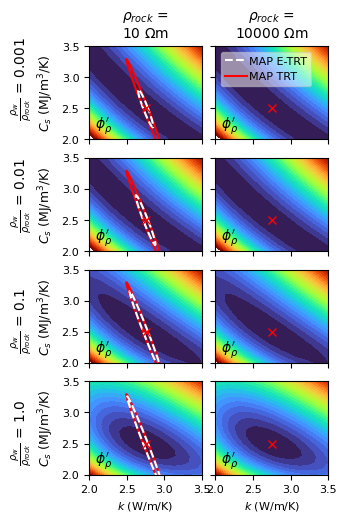

In [91]:
import matplotlib.lines as mlines

fig, ax = plt.subplots(4, 2, figsize=(8/2.54, 13/2.54), constrained_layout=True, sharex=True, sharey=True, gridspec_kw={'wspace': 0.05, 'hspace': 0.05})

for i in range(4):
    covariance_ellipse(C_rtrt[:2, :2], [k, C], ax[i, 0], 'r-')
    covariance_ellipse(C_r10[i][:2, :2], [k, C], ax[i, 0], 'w--')
    
ax = ax.flatten()

for idx, ((rho_rock, rho_w), phi) in enumerate(filtered_items):
    im = add_panel(ax[idx], phi, 'chi2R_norm', 'chi2T_norm', kg2, Cg3, onlyR=True)
    
    row = ratios.index(rho_w / rho_rock)
    col = rho_rock_values.index(rho_rock)

    if col == 0:
        ax[idx].set_ylabel(rf"$\rho_w/\rho_{{rock}}$ = {ratios[-row]}", fontsize=10)
        
marker_trt = mlines.Line2D([], [], color='w', linestyle='--', label='MAP E-TRT')
marker_etrt = mlines.Line2D([], [], color='r', linestyle='-', label='MAP TRT')

ax[1].legend(handles=[marker_trt, marker_etrt], loc='upper left', handletextpad=0.1, fontsize=8, framealpha=0.5)        
ax[0].set_xlim(2, 3.5)
ax[0].set_ylim(2, 3.5)

ax[0].set_title(f"$\\rho_{{rock}}$ = \n10 $\Omega$m", fontsize=10)
ax[1].set_title(f"$\\rho_{{rock}}$ = \n10000 $\Omega$m", fontsize=10)

ax[0].set_ylabel(r'$C_s$ (MJ/m$^3$/K)', fontsize=9)
ax[2].set_ylabel(r'$C_s$ (MJ/m$^3$/K)', fontsize=9)
ax[4].set_ylabel(r'$C_s$ (MJ/m$^3$/K)', fontsize=9)
ax[6].set_ylabel(r'$C_s$ (MJ/m$^3$/K)', fontsize=9)

ax[6].set_xlabel('$k$ (W/m/K)')
ax[7].set_xlabel('$k$ (W/m/K)')

ax[0].annotate(rf"$\frac{{\rho_w}}{{\rho_{{rock}}}}$ = {ratios[3]}", xy=(-0.7, 0.2), xycoords='axes fraction',fontsize=10, ha='left', va='bottom',rotation=90)
ax[2].annotate(rf"$\frac{{\rho_w}}{{\rho_{{rock}}}}$ = {ratios[2]}", xy=(-0.7, 0.2), xycoords='axes fraction',fontsize=10, ha='left', va='bottom',rotation=90)
ax[4].annotate(rf"$\frac{{\rho_w}}{{\rho_{{rock}}}}$ = {ratios[1]}", xy=(-0.7, 0.1), xycoords='axes fraction',fontsize=10, ha='left', va='bottom',rotation=90)
ax[6].annotate(rf"$\frac{{\rho_w}}{{\rho_{{rock}}}}$ = {ratios[0]}", xy=(-0.7, 0.1), xycoords='axes fraction',fontsize=10, ha='left', va='bottom',rotation=90)

for a in ax:
    a.text(0.05, 0.03, '$\phi_\\rho\'$', ha='left', va='bottom', transform=a.transAxes, fontsize=10, color='black')
    a.plot(k, C, 'rx', markersize=6,  markerfacecolor='none')


#plt.savefig("06-figures/ratio_vs_rhorock_grid.pdf", format='pdf', bbox_inches='tight', pad_inches=0)

The sensitivity of the electrical data to the thermal parameters diminishes when the water in the SCW becomes more conductive in comparison with the bedrock.